In [1]:
import jax.numpy as jnp
from jax import grad, jit, value_and_grad, make_jaxpr, config
from jax import random, profiler, config, debug, lax
from jax.nn import sigmoid
import numpy as np
import jax
import optax
import h5py

from larndsim.sim_jax import prepare_tracks, simulate_parametrized
from larndsim.softdtw_jax import SoftDTW
from larndsim.consts_jax import build_params_class, load_detector_properties
from numpy.lib import recfunctions as rfn
from larndsim.quenching_jax import quench
from larndsim.drifting_jax import drift
import matplotlib.pyplot as plt

import matplotlib
import matplotlib.cm as cm
from tqdm import tqdm
from larndsim.sim_jax import simulate_signals_parametrized, simulate_drift, pad_size
from larndsim.detsim_jax import id2pixel, get_pixel_coordinates, current_mc, accumulate_signals_parametrized
from larndsim.fee_jax import get_adc_values, digitize
matplotlib.rcParams.update({'font.size': 14})

jax.config.update('jax_platform_name', 'cpu')

%config InlineBackend.figure_format='retina'

In [2]:
from optimize.dataio import pad_sequence

# to_propagate = ('Ab', 'kb', 'long_diff', 'tran_diff', 'eField', 'lifetime')#, 'shift_x', 'shift_y', 'shift_z')
to_propagate = ('shift_x', 'shift_y', 'shift_z')
#Running some fit
Params = build_params_class(to_propagate)
ref_params = load_detector_properties(Params, "./src/larndsim/detector_properties/module0.yaml",
                                "./src/larndsim/pixel_layouts/multi_tile_layout-2.4.16_v4.yaml")
ref_params = ref_params.replace(Ab=0.8, kb=0.0486, tran_diff=4.0e-6, long_diff=8.8e-6, number_pix_neighbors=0, signal_length=100, electron_sampling_resolution=5e-3, eField=0.5, lifetime=3e3, time_padding=190)
ref_params = ref_params.replace(time_window=ref_params.signal_length)
# ref_params = ref_params.replace(RESET_NOISE_CHARGE=0., UNCORRELATED_NOISE_CHARGE=0., lifetime=1e10, long_diff=0., tran_diff=0.)
# ref_params = ref_params.replace(RESET_NOISE_CHARGE=0.)
# ref_params = ref_params.replace(UNCORRELATED_NOISE_CHARGE=0.)

tracks_files = [
    './prepared_data/input_1.h5',
    './prepared_data/input_2.h5',
    './prepared_data/input_3.h5',
    './prepared_data/input_4.h5'
]
tracks = None
for tracks_file in tracks_files:
    tracks_loc, fields, _ = prepare_tracks(ref_params, tracks_file, False)
    if tracks is None:
        tracks = tracks_loc
    else:
        tracks = jnp.concatenate([tracks, tracks_loc])




In [3]:
from larndsim.consts_jax import load_lut
from optimize.simulate import load_events_as_batch
from larndsim.sim_jax import simulate_signals_new, simulate_drift_new, get_renumbering
Params = build_params_class([])
ref_params = load_detector_properties(Params,
                                      "/Users/pgranger/larnd-sim-jax/src/larndsim/detector_properties/module0.yaml",
                                      'src/larndsim/pixel_layouts/multi_tile_layout-2.4.16_v4.yaml')

master_key = jax.random.key(0)
rngkey1, rngkey2 = jax.random.split(master_key)

ref_params = ref_params.replace(
    signal_length=150,
    number_pix_neighbors=4,
    electron_sampling_resolution=0.005,
    mc_diff=True,
    UNCORRELATED_NOISE_CHARGE=0.0,
)

response = load_lut("src/larndsim/detector_properties/response_44.npy")

# dataset, fields = load_events_as_batch("event122.h5", ref_params.electron_sampling_resolution, swap_xz=True)
# tracks = dataset[0]

main_pixels, pixels, nelectrons, t0_after_diff, currents_idx, pIDs_neigh, currents_idx_neigh, nelectrons_neigh, t0_neigh = simulate_drift_new(ref_params, tracks, fields)

################################################
################################################

#Sorting the pixels and getting the unique ones
unique_pixels = jnp.unique(main_pixels.ravel())
padded_size = pad_size(unique_pixels.shape[0], "unique_pixels")

unique_pixels = jnp.sort(jnp.pad(unique_pixels, (0, padded_size - unique_pixels.shape[0]), mode='constant', constant_values=-1))

mask, pix_renumbering_neigh = get_renumbering(pIDs_neigh, unique_pixels)
mask_indices = jnp.nonzero(mask)[0]
padded_size = pad_size(mask_indices.shape[0], "pix_renumbering")
mask_indices = jnp.pad(mask_indices, (0, padded_size - mask_indices.shape[0]), mode='constant', constant_values=-1)

###############################################
###############################################

wfs = simulate_signals_new(ref_params, unique_pixels, pixels, t0_after_diff, response, nelectrons, currents_idx, nelectrons_neigh, mask_indices, pix_renumbering_neigh, t0_neigh, currents_idx_neigh)

nsim = 1000

results = np.zeros((nsim, unique_pixels.shape[0], 10))
results_ticks = np.zeros((nsim, unique_pixels.shape[0], 10))

for i in tqdm(range(nsim)):
    _, rngkey2 = jax.random.split(rngkey2)

    integral, ticks = get_adc_values(ref_params, wfs[:, 1:], rngkey2)
    adcs = digitize(ref_params, integral)

    results[i] = adcs
    results_ticks[i] = ticks


100%|██████████| 1000/1000 [01:19<00:00, 12.51it/s]


In [ ]:
pars_no_noise = ref_params.replace(RESET_NOISE_CHARGE=0., UNCORRELATED_NOISE_CHARGE=0.)


master_key = jax.random.key(0)
rngkey1, rngkey2 = jax.random.split(master_key)
electrons, pIDs = simulate_drift(ref_params, tracks, fields, rngkey1)
pIDs = pIDs.ravel()
unique_pixels = jnp.unique(pIDs)
padded_size = pad_size(unique_pixels.shape[0], "unique_pixels")

unique_pixels = jnp.sort(jnp.pad(unique_pixels, (0, padded_size - unique_pixels.shape[0]), mode='constant', constant_values=-1))

# offset_adcs, ticks, pix_renumbering, start_ticks = simulate_signals_parametrized(offset_pars, electrons, pIDs, unique_pixels, rngkey2, True, fields)

xpitch, ypitch, plane, eid = id2pixel(ref_params, pIDs)

pixels_coord = get_pixel_coordinates(ref_params, xpitch, ypitch, plane)
t0, signals = current_mc(ref_params, electrons, pixels_coord, fields)

pix_renumbering = jnp.searchsorted(unique_pixels, pIDs)

nticks_wf = int(ref_params.time_interval[1]/ref_params.t_sampling) + 1 #Adding one first element to serve as a garbage collector
wfs = jnp.zeros((unique_pixels.shape[0], nticks_wf))

#TODO: Check what should be the correct implementation: when is the actual trigger reference time?
start_ticks = t0 #- signals.shape[1]

wfs = accumulate_signals_parametrized(wfs, signals, pix_renumbering, start_ticks)
# offset_adcs = jnp.repeat(jnp.sum(wfs[:, 1:], axis=-1), 10).reshape(-1, 10)

# offset_adcs = jnp.zeros((len(unique_pixels), 10), dtype=jnp.float32)
# offset_adcs = offset_adcs.at[pix_renumbering, 0].add(1)

_, rngkey2 = jax.random.split(rngkey2)

integral, ticks_nonoise = get_adc_values(pars_no_noise, wfs[:, 1:], rngkey2)
adcs_nonoise = digitize(pars_no_noise, integral)


In [ ]:

# interesting_vars = [p for p in to_propagate if 'shift' not in p]

# nb_pix = 10

master_key = jax.random.key(0)
rngkey1, rngkey2 = jax.random.split(master_key)
electrons, pIDs = simulate_drift(ref_params, tracks, fields, rngkey1)
pIDs = pIDs.ravel()
unique_pixels = jnp.unique(pIDs)
padded_size = pad_size(unique_pixels.shape[0], "unique_pixels")

unique_pixels = jnp.sort(jnp.pad(unique_pixels, (0, padded_size - unique_pixels.shape[0]), mode='constant', constant_values=-1))

# offset_adcs, ticks, pix_renumbering, start_ticks = simulate_signals_parametrized(offset_pars, electrons, pIDs, unique_pixels, rngkey2, True, fields)

xpitch, ypitch, plane, eid = id2pixel(ref_params, pIDs)

pixels_coord = get_pixel_coordinates(ref_params, xpitch, ypitch, plane)
t0, signals = current_mc(ref_params, electrons, pixels_coord, fields)

pix_renumbering = jnp.searchsorted(unique_pixels, pIDs)

nticks_wf = int(ref_params.time_interval[1]/ref_params.t_sampling) + 1 #Adding one first element to serve as a garbage collector
wfs = jnp.zeros((unique_pixels.shape[0], nticks_wf))

#TODO: Check what should be the correct implementation: when is the actual trigger reference time?
start_ticks = t0 #- signals.shape[1]

wfs = accumulate_signals_parametrized(wfs, signals, pix_renumbering, start_ticks)
# offset_adcs = jnp.repeat(jnp.sum(wfs[:, 1:], axis=-1), 10).reshape(-1, 10)

# offset_adcs = jnp.zeros((len(unique_pixels), 10), dtype=jnp.float32)
# offset_adcs = offset_adcs.at[pix_renumbering, 0].add(1)

nsim = 1000

results = np.zeros((nsim, unique_pixels.shape[0], 10))
results_ticks = np.zeros((nsim, unique_pixels.shape[0], 10))

for i in tqdm(range(nsim)):
    _, rngkey2 = jax.random.split(rngkey2)

    integral, ticks = get_adc_values(ref_params, wfs[:, 1:], rngkey2)
    adcs = digitize(ref_params, integral)

    results[i] = adcs
    results_ticks[i] = ticks



100%|██████████| 1000/1000 [16:11<00:00,  1.03it/s]


100%|██████████| 1000/1000 [00:00<00:00, 10009.79it/s]


(array([ 1.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  1.,  1.,  1.,
         2.,  0.,  1.,  3.,  2.,  4.,  7.,  4.,  5.,  6.,  8.,  6.,  6.,
        10.,  9., 13.,  6., 16., 16., 15., 10., 18., 18., 17., 19., 28.,
        23., 25., 18., 30., 32., 31., 31., 28., 24., 29., 39., 23., 32.,
        25., 28., 27., 23., 25., 28., 21., 22., 13., 18., 14., 13., 11.,
        10., 14.,  6., 14.,  8., 13.,  7.,  3.,  3.,  3.,  3.,  4.,  3.,
         3.,  2.,  5.,  1.,  3.,  1.,  1.,  0.,  3.,  1.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([-3141.31982422, -3076.11352539, -3010.9074707 , -2945.70117188,
        -2880.49511719, -2815.28881836, -2750.08251953, -2684.87646484,
        -2619.67016602, -2554.46386719, -2489.2578125 , -2424.05151367,
        -2358.84521484, -2293.63916016, -2228.43286133, -2163.2265625 ,
        -2098.02050781, -2032.81433105, -1967.6081543 , -1902.40185547,
        -1837.19567871, -1771.98950195, -1706.78320312, -1641.57702637,
  

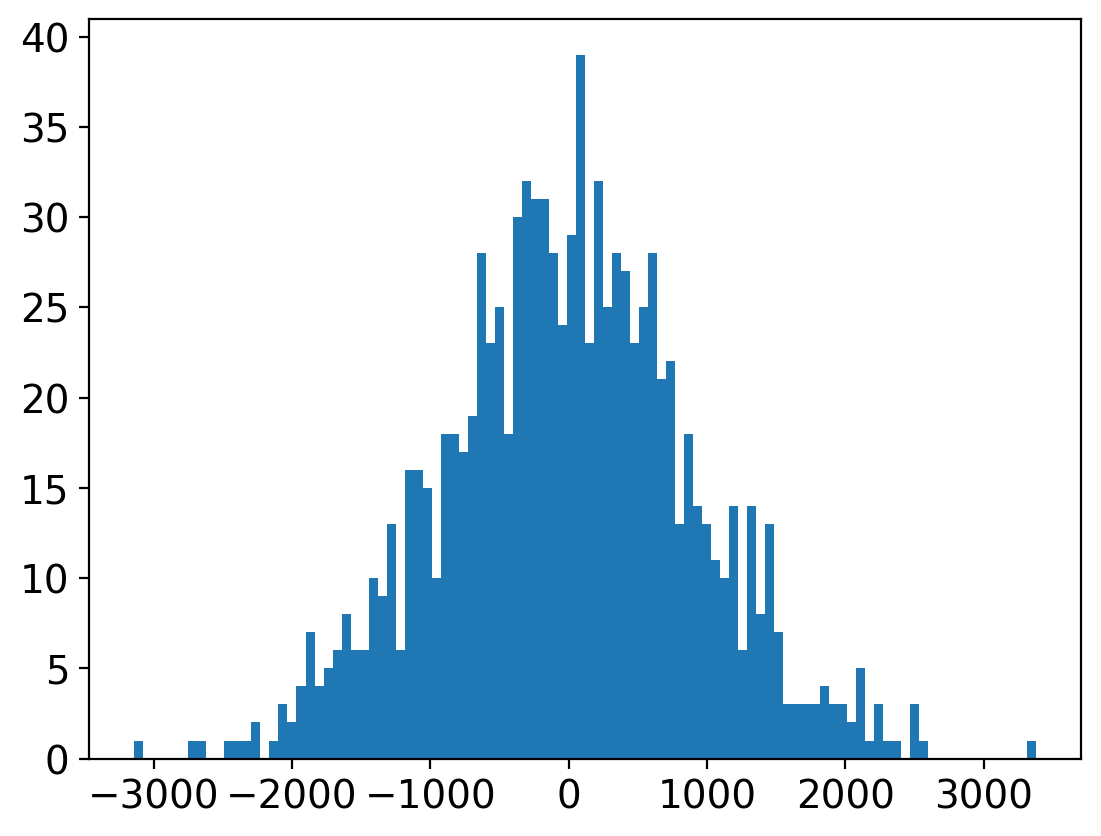

In [17]:
rngkey1, rngkey2 = jax.random.split(master_key)
values = []
for i in tqdm(range(nsim)):
    _, rngkey2 = jax.random.split(rngkey2)
    value = random.normal(rngkey2, (wfs.shape[0],))[iplot]*ref_params.RESET_NOISE_CHARGE
    values.append(value)
plt.hist(values, bins=100)

In [148]:
@jit
def get_adc_values_average_noise(params, pixels_signals):
    q = pixels_signals*params.t_sampling
    q_sum = q.cumsum(axis=-1)  # Cumulative sum over time ticks


    def find_hit(carry, it):
        q_sum_loc, previous_prob = carry
        sigma = params.RESET_NOISE_CHARGE #Found out that only considering the reset noise was sufficient
        # sigma = jnp.sqrt(sigma**2 + params.UNCORRELATED_NOISE_CHARGE**2)
        signal = jnp.frompyfunc(jnp.maximum, 2, 1).accumulate(q_sum_loc, axis=-1)
        eps = 1e-10
        # signal = q_sum_loc
        guess = 0.5*(erf((signal[:, 1:] - params.DISCRIMINATION_THRESHOLD)/(jnp.sqrt(2)*sigma)) - erf((signal[:, :-1] - params.DISCRIMINATION_THRESHOLD)/(jnp.sqrt(2)*sigma)))
        norm = 0.5*(erf((signal[:, -1] - params.DISCRIMINATION_THRESHOLD)/(jnp.sqrt(2)*sigma)) + 1)# - erf((signal[:, 1] - params.DISCRIMINATION_THRESHOLD)/(jnp.sqrt(2)*sigma)))
        

        interval = round((3 * params.CLOCK_CYCLE + params.ADC_HOLD_DELAY * params.CLOCK_CYCLE) / params.t_sampling)

        # tick_avg  = jnp.sum(guess/ (1-no_hit_prob[:, None])*jnp.arange(guess.shape[1]), axis=1) + 0.5
        

        shifted_ticks = jnp.arange(guess.shape[1]) + interval + 1

        shifted_ticks = jnp.clip(shifted_ticks, 0, q_sum_loc.shape[1] - 1)
        # shifted_ticks2 = jnp.clip(shifted_ticks + 1, 0, q_sum_loc.shape[1] - 1)

        # prob_charge_pass = (1 + erf(-(ref_params.DISCRIMINATION_THRESHOLD - q_sum_loc[:, shifted_ticks])/(jnp.sqrt(2)*sigma))) / (1 + erf(-(ref_params.DISCRIMINATION_THRESHOLD - q_sum_loc[:, 1:])/(jnp.sqrt(2)*sigma)) + 1e-5)
        prob_charge_pass = (erf((q_sum_loc[:, shifted_ticks] - params.DISCRIMINATION_THRESHOLD)/(jnp.sqrt(2)*sigma)) - erf((q_sum_loc[:, :-1] - params.DISCRIMINATION_THRESHOLD)/(jnp.sqrt(2)*sigma)))/(erf((signal[:, 1:] - params.DISCRIMINATION_THRESHOLD)/(jnp.sqrt(2)*sigma)) - erf((signal[:, :-1] - params.DISCRIMINATION_THRESHOLD)/(jnp.sqrt(2)*sigma)) + eps)
        prob_charge_pass = jnp.clip(prob_charge_pass, 0, 1)
        # prob_charge_pass = q_sum_loc[:, shifted_ticks] > 0.5*(signal[:, 1:] + signal[:, :-1])  # This is a simplified version of the charge passing probability
        # prob_charge_pass= 1
        # esperance_value = q_sum_loc[:, shifted_ticks] + 0.5*sigma*(normpdf.pdf(q_sum_loc[:, :-1], loc=params.DISCRIMINATION_THRESHOLD, scale=sigma) - normpdf.pdf(q_sum_loc[:, 1:], loc=params.DISCRIMINATION_THRESHOLD, scale=sigma))/(erf((signal[:, 1:] - params.DISCRIMINATION_THRESHOLD + eps)/(jnp.sqrt(2)*sigma)) - erf((signal[:, :-1] - params.DISCRIMINATION_THRESHOLD + eps)/(jnp.sqrt(2)*sigma)) + 1e-5)
        esperance_value = q_sum_loc[:, shifted_ticks] + params.DISCRIMINATION_THRESHOLD - 0.5*(signal[:, 1:] + signal[:, :-1])

        actual_norm = jnp.sum(guess*prob_charge_pass, axis=1) + eps  # Adding a small epsilon to avoid division by zero
        debug.print("actual norm: {a}", a=actual_norm)
        charge_avg1 = (jnp.sum(guess*prob_charge_pass*esperance_value, axis=1)/(actual_norm))
        # charge_avg2 = jnp.sum(guess*q_sum_loc[:, shifted_ticks2], axis=1)[:, jnp.newaxis]

        # charge_avg = jnp.clip(0.5*(charge_avg1 + charge_avg2)/norm[:, jnp.newaxis], params.DISCRIMINATION_THRESHOLD, None)
        # charge_avg = jnp.clip(charge_avg1, params.DISCRIMINATION_THRESHOLD, None)
        charge_avg = charge_avg1

        tick_avg  = jnp.sum(guess*prob_charge_pass/(actual_norm[:, None])*jnp.arange(guess.shape[1]), axis=1)# + 0.5
        tick_mpv = jnp.argmax(guess*prob_charge_pass, axis=1)  # This is the most probable tick where the charge passes the threshold

        # charge_avg = q_sum_loc[jnp.arange(charge_avg.shape[0]), jnp.clip(tick_avg.astype(jnp.int32) + interval + 1, 0, q_sum_loc.shape[1] - 1)]

        # q_sum_new = q_sum_loc - charge_avg[:, jnp.newaxis]
        # q_sum_new = q_sum_loc - charge_avg1[:, jnp.newaxis]
        print(tick_mpv.shape)
        print(esperance_value[jnp.arange(esperance_value.shape[0]), tick_mpv.astype(jnp.int32)].shape)
        q_sum_new = q_sum_loc - esperance_value[jnp.arange(esperance_value.shape[0]), tick_mpv.astype(jnp.int32)][:, None]
        # q_sum_new = q_sum_loc - (q_sum_loc[jnp.arange(q_sum_loc.shape[0]), tick_avg.astype(jnp.int32) + interval + 1 + 1])[:, None]
        # q_sum_new = q_sum_loc - (q_sum_loc[jnp.arange(q_sum_loc.shape[0]), tick_mpv.astype(jnp.int32) + interval + 1 + 1])[:, None]
        # q_sum_new = jnp.clip(q_sum_new, 0, None)  # Ensure no negative values
        no_hit_prob = 1 - actual_norm

        return (q_sum_new, previous_prob), (charge_avg, tick_avg, no_hit_prob, guess)
    
    init_loop = (q_sum, jnp.ones((q_sum.shape[0],)))  # Initialize previous_prob
    _, (charge_avg, tick_avg, no_hit_prob, guess) = lax.scan(find_hit, init_loop, jnp.arange(0, params.MAX_ADC_VALUES))
    # carry, (charge_avg, tick_avg, no_hit_prob, guess) = find_hit(init_loop, 0)
    # carry, (charge_avg, tick_avg, no_hit_prob, guess) = find_hit(carry, 1)
    return (charge_avg, tick_avg, no_hit_prob, guess)

[[9.6559525e-04 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 7.1289396e-01]
 [1.1324883e-06 9.9998915e-01 8.7834215e-01 ... 2.1693516e-01
  2.3841858e-07 1.0000000e+00]
 [9.9996853e-01 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 1.0000000e+00]]
charge_avg shape: (3, 1081) tick_avg shape: (3, 1081) no_hit_prob shape: (3, 1081) guess shape: (3, 1081, 100, 1999)


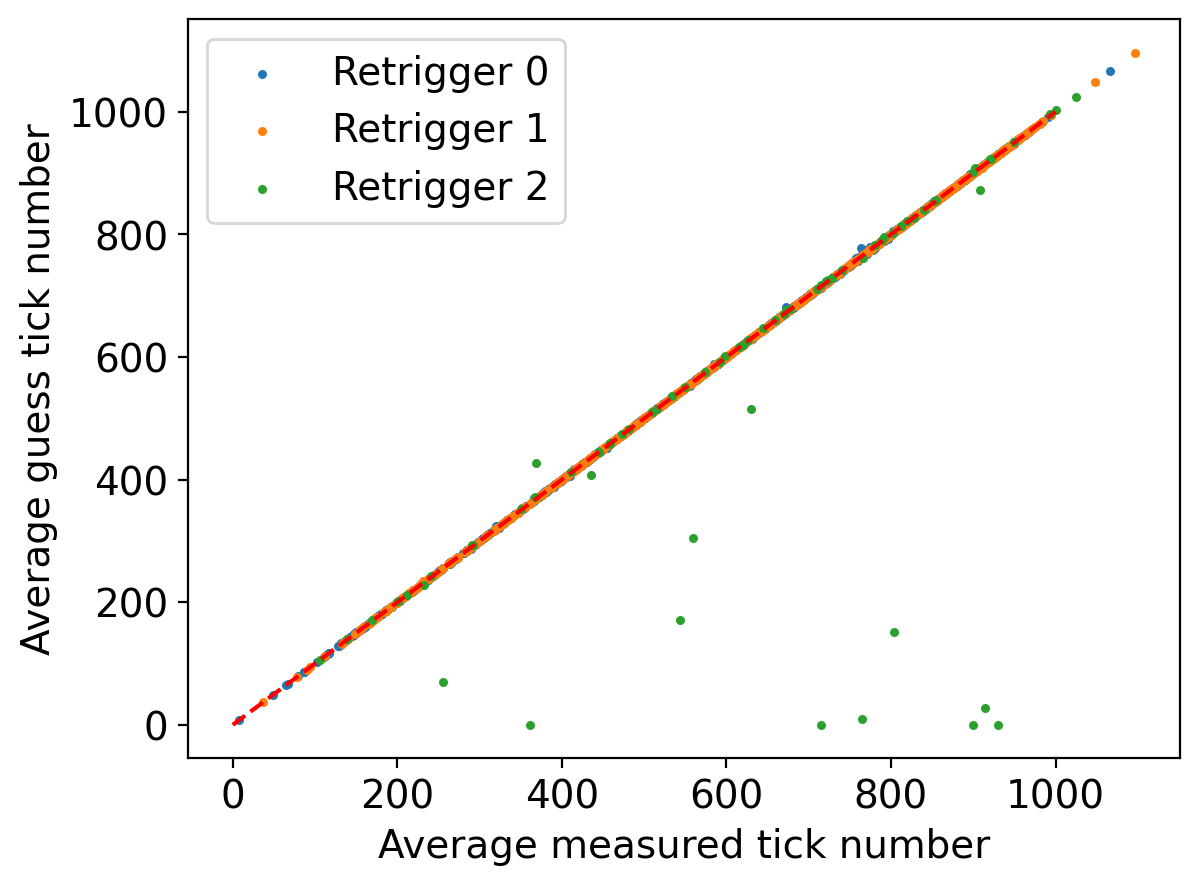

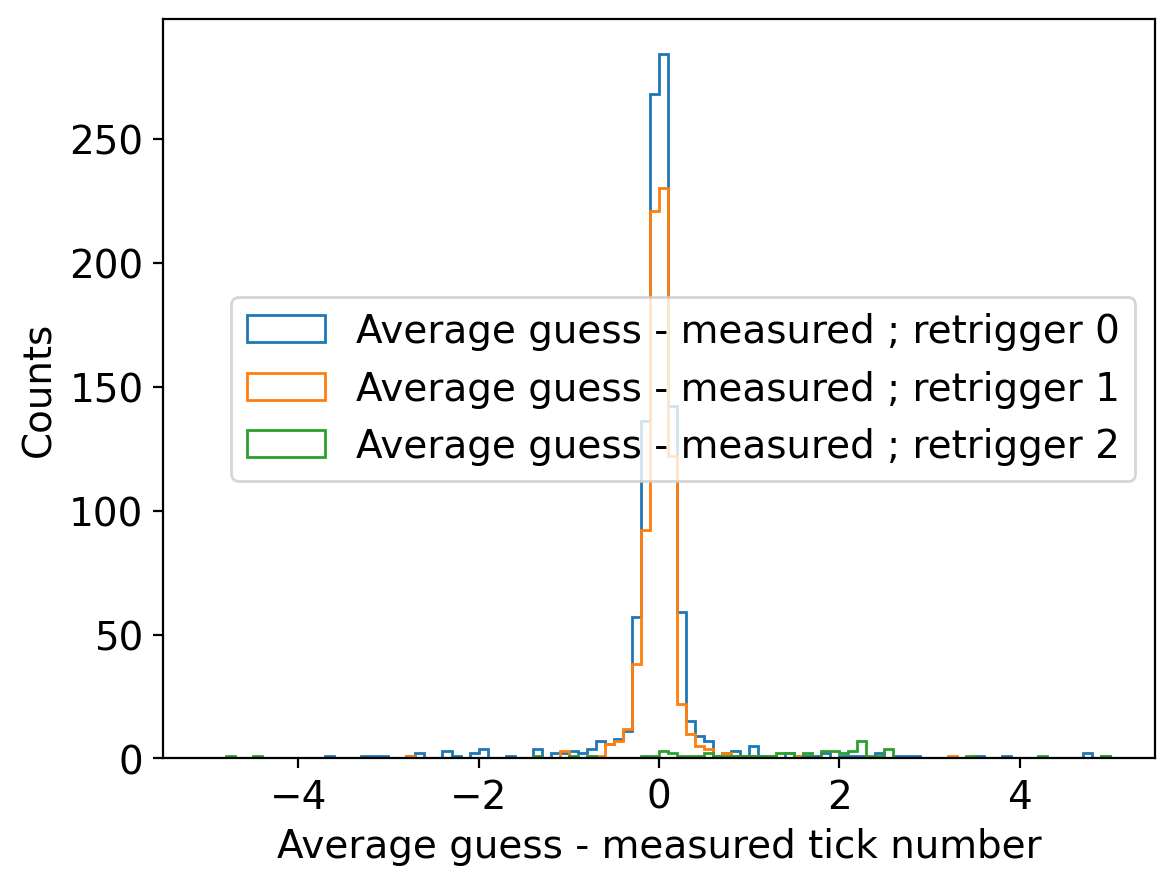

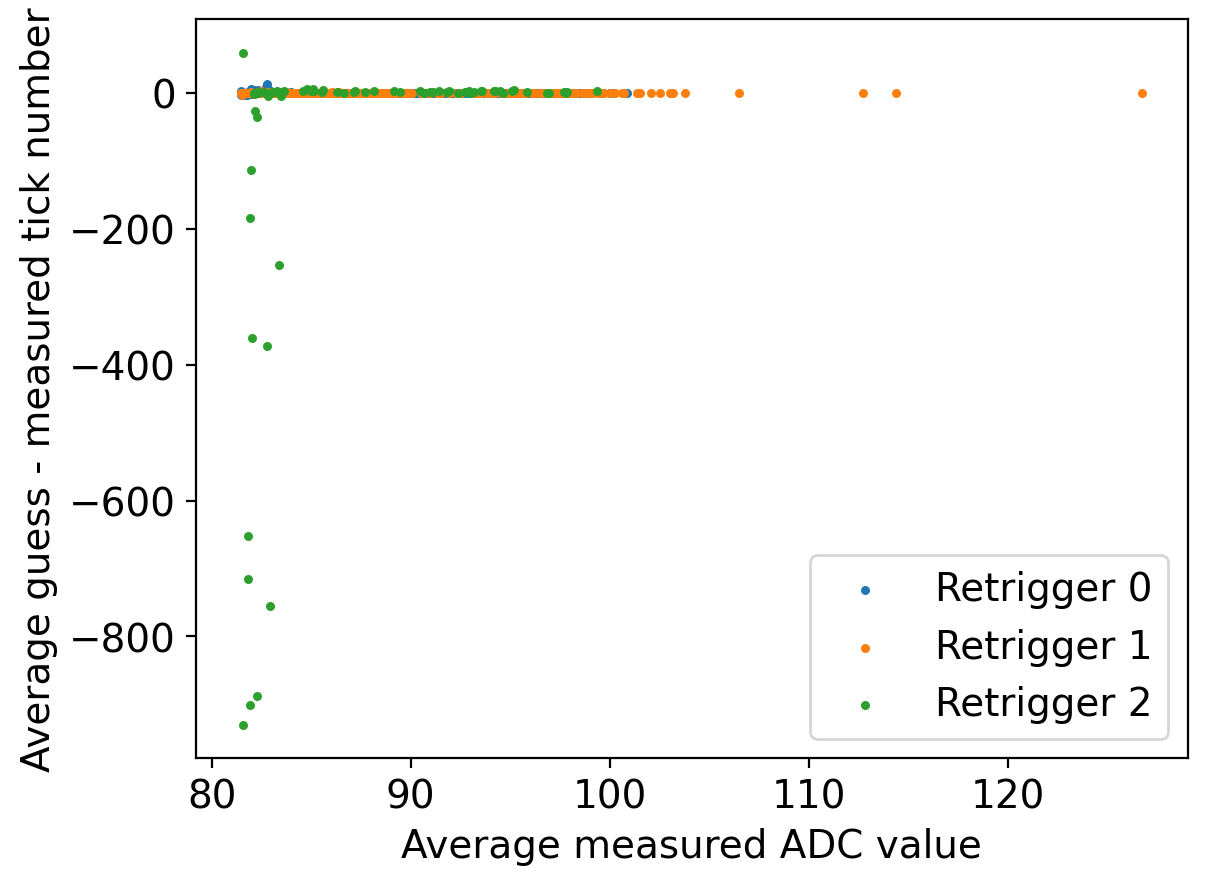

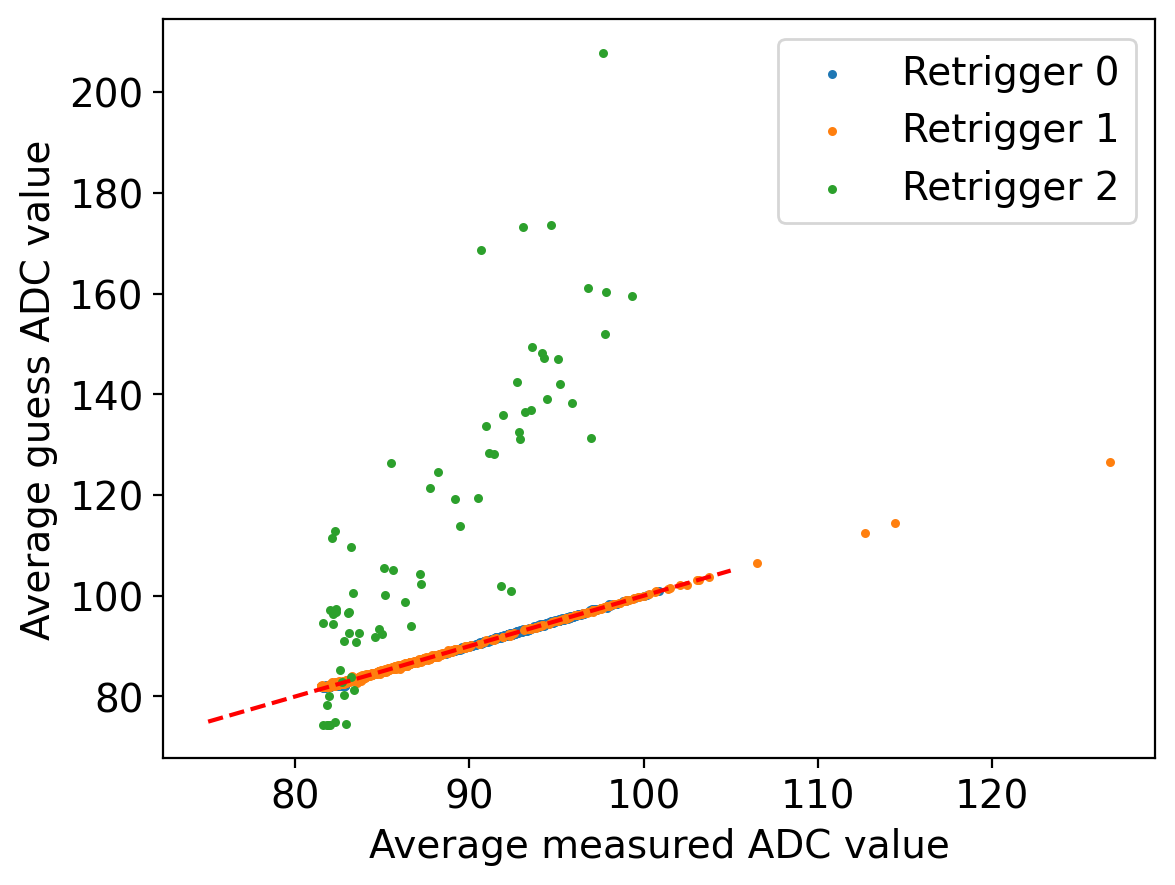

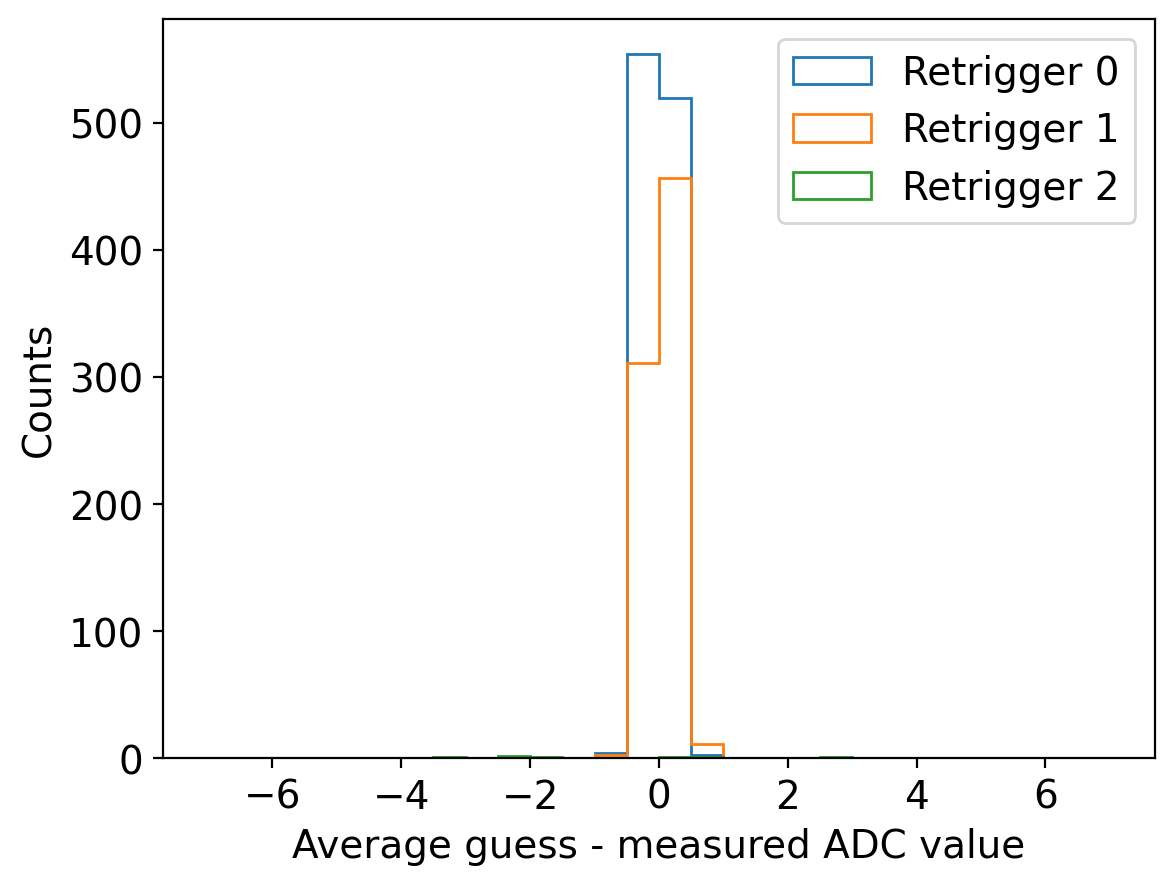

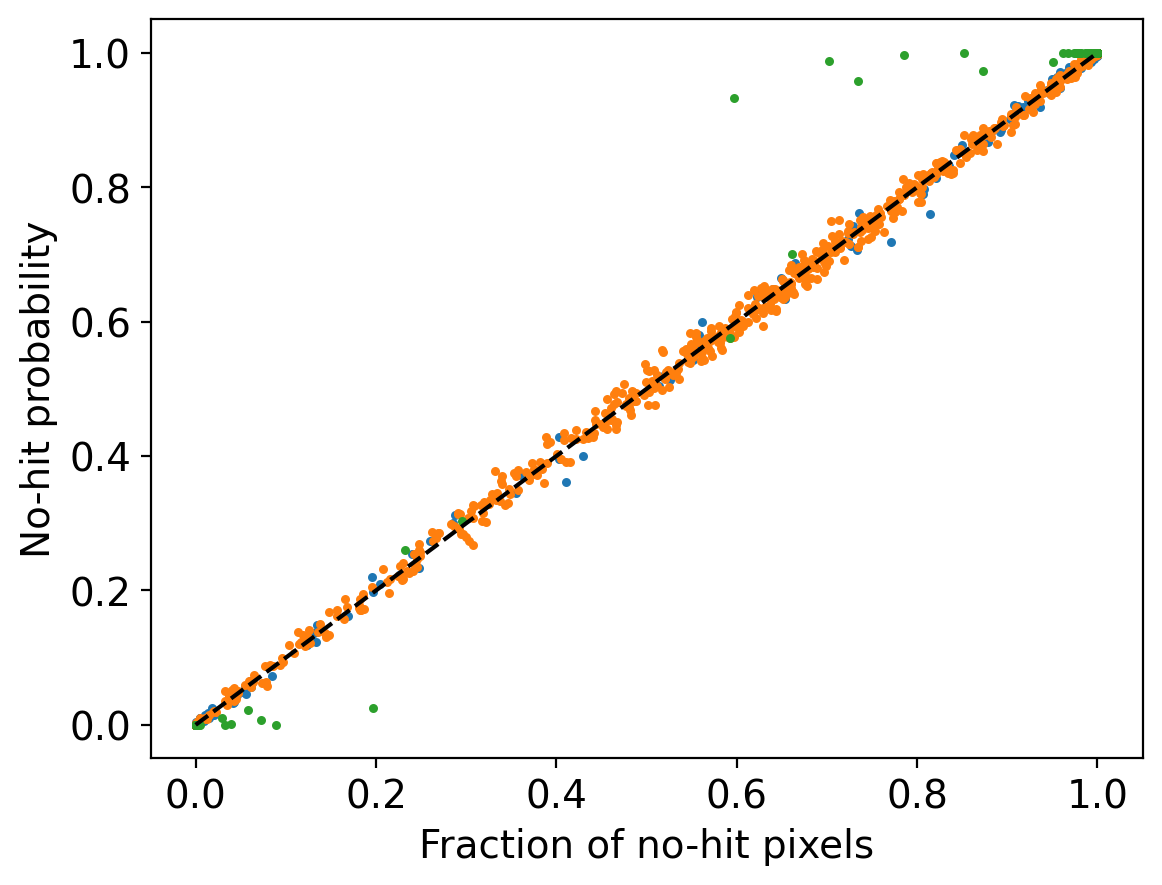

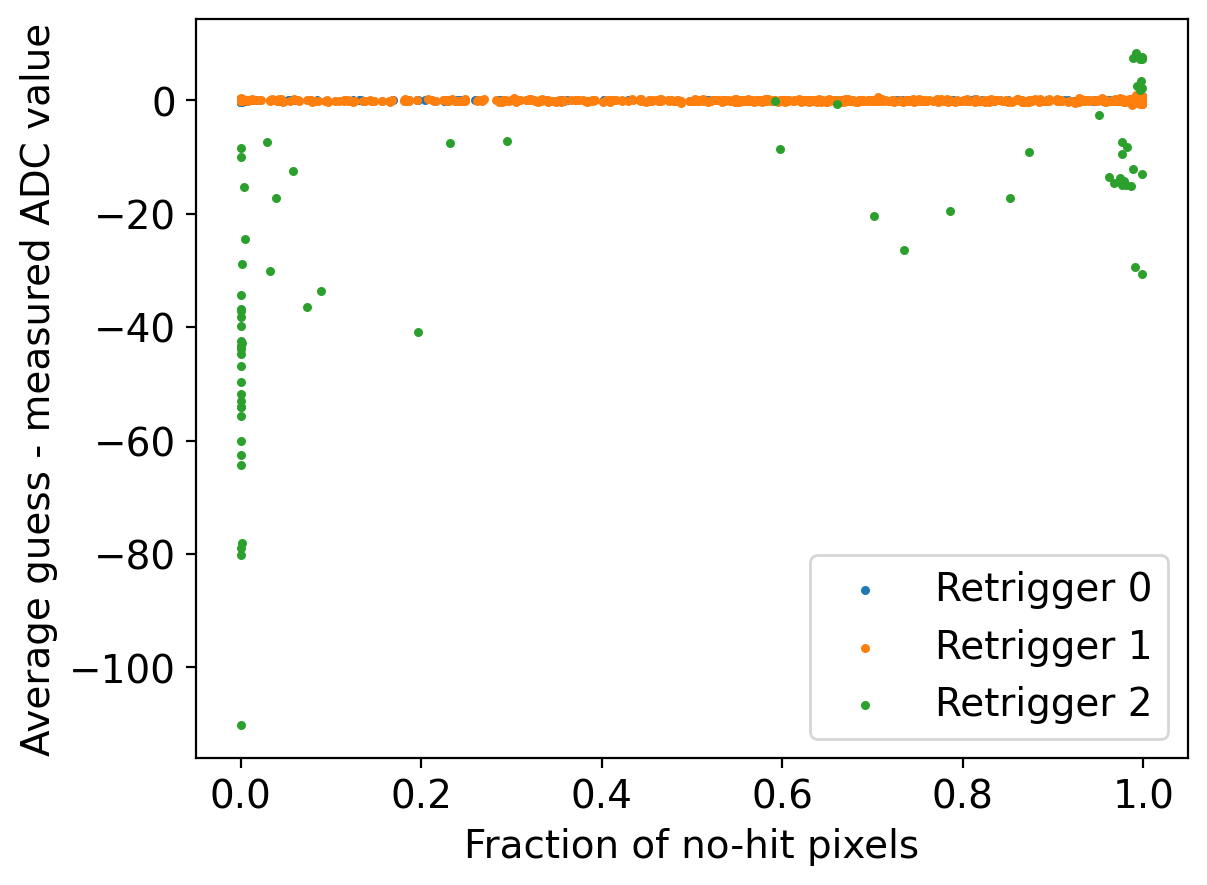

In [385]:
from jax.scipy.special import erf
from jax.scipy.stats import norm as normpdf
from jax import debug

@jit
def get_adc_values_average_noise(params, pixels_signals):
    q = pixels_signals*params.t_sampling
    q_sum = q.cumsum(axis=-1)  # Cumulative sum over time ticks

    N_universe = 100


    def find_hit(carry, it):
        q_sum_loc, previous_prob = carry
        sigma = params.RESET_NOISE_CHARGE #Found out that only considering the reset noise was sufficient
        eps = 1e-10

        Npix, _, Nticks = q_sum_loc.shape

        signal = jnp.frompyfunc(jnp.maximum, 2, 1).accumulate(q_sum_loc, axis=-1)
        guess = 0.5*(erf((signal[..., 1:] - params.DISCRIMINATION_THRESHOLD)/(jnp.sqrt(2)*sigma)) - erf((signal[..., :-1] - params.DISCRIMINATION_THRESHOLD)/(jnp.sqrt(2)*sigma)))
        guess = jnp.clip(guess, 0, 1)  # Ensure guess is between 0 and 1, should not be needed but erf got odd behavior for some reason

        interval = round((3 * params.CLOCK_CYCLE + params.ADC_HOLD_DELAY * params.CLOCK_CYCLE) / params.t_sampling)
        shifted_ticks = jnp.arange(Nticks - 1) + interval + 1
        shifted_ticks = jnp.clip(shifted_ticks, 0, Nticks - 1)

        prob_charge_pass = (
            erf((q_sum_loc[..., shifted_ticks] - params.DISCRIMINATION_THRESHOLD)/(jnp.sqrt(2)*sigma))
            - erf((q_sum_loc[..., :-1] - params.DISCRIMINATION_THRESHOLD)/(jnp.sqrt(2)*sigma))
            )/(2*guess + eps)
        prob_charge_pass = jnp.clip(prob_charge_pass, 0, 1)

        esperance_value = q_sum_loc[..., shifted_ticks] + params.DISCRIMINATION_THRESHOLD - 0.5*(signal[..., 1:] + signal[..., :-1])

        norm = jnp.clip(jnp.sum(guess*prob_charge_pass, axis=-1) + eps, 0, 1)  # Adding a small epsilon to avoid division by zero
        # debug.print("Norm: {a}", a=norm)
        previous_prob_norm = jnp.sum(previous_prob, axis=1) + eps  # Avoid division by zero
        hit_prob_across = jnp.sum(norm*previous_prob, axis=1)/previous_prob_norm  # Average no-hit probability across universes
        no_hit_prob_across = 1 - hit_prob_across
        prob_distrib = guess*prob_charge_pass*previous_prob[..., None]

        prob_distrib_across = jnp.sum(prob_distrib, axis=1)
        norm_across = jnp.sum(prob_distrib_across, axis=1) + eps
        # tick_avg = jnp.sum(prob_distrib_across*jnp.arange(Nticks - 1), axis=-1)/norm_across  # + 0.5
        tick_avg = jnp.sum(prob_distrib_across/(norm_across[:, None])*jnp.arange(Nticks - 1), axis=-1)  # + 0.5
        # debug.print("prob_distrib_across: {a}", a=guess.flatten()[12801], ordered=True)
        # debug.print("a: {a}", a=erf((signal[..., 1:] - params.DISCRIMINATION_THRESHOLD)/(jnp.sqrt(2)*sigma)).flatten()[12801], ordered=True)
        # debug.print("b: {a}", a=erf((signal[..., :-1] - params.DISCRIMINATION_THRESHOLD)/(jnp.sqrt(2)*sigma)).flatten()[12801], ordered=True)
        # debug.print("a2: {a}", a=signal[..., 1:].flatten()[12801], ordered=True)
        # debug.print("b2: {a}", a=signal[..., :-1].flatten()[12801], ordered=True)
        # debug.print("norm_across: {a}", a=norm_across, ordered=True)
        # debug.print("tick_avg: {a}", a=tick_avg, ordered=True)

        charge_avg = (jnp.sum(guess*prob_charge_pass*esperance_value, axis=-1))
        # print("Charge avg shape:", charge_avg.shape)
        # print("Previous prob shape:", previous_prob.shape)
        # print("Norm across shape:", norm_across.shape)
        # print("Previous prob norm shape:", previous_prob_norm.shape)
        # print("Sum shape:", jnp.sum(charge_avg*previous_prob, axis=1).shape)
        charge_avg_across = jnp.sum(charge_avg*previous_prob, axis=1)/previous_prob_norm/norm_across  # Average charge across universes

        best_paths = jnp.argsort(prob_distrib.reshape(Npix, -1), axis=-1, descending=True)[:, :N_universe]
        best_path_universe = best_paths // Nticks
        best_path_ticks = best_paths % Nticks

        best_path_next_ticks = jnp.clip(shifted_ticks + 1, 0, Nticks - 1)
        best_path_esperance = q_sum_loc[..., best_path_next_ticks][jnp.arange(Npix)[:, None], best_path_universe, best_path_ticks]
        best_path_wfs = q_sum_loc[jnp.arange(Npix)[:, None], best_path_universe, :]
        q_sum_new = best_path_wfs - best_path_esperance[..., None]
        # q_sum_new = jnp.clip(q_sum_new, 0, None)  # Ensure no negative values
        new_prob = prob_distrib[jnp.arange(Npix)[:, None], best_path_universe, best_path_ticks]
        leftover = jnp.sum(prob_distrib_across, axis=1) - jnp.sum(new_prob, axis=1)  # Leftover probability after taking the best paths

        return (q_sum_new, new_prob), (charge_avg_across, tick_avg, no_hit_prob_across, guess, leftover)
    
    q_sum_multi = jnp.zeros((q_sum.shape[0], N_universe, q_sum.shape[1]), dtype=jnp.float32)  # Initialize q_sum for multiple universes
    q_sum_multi = q_sum_multi.at[:, 0, :].set(q_sum)
    previous_prob = jnp.zeros((q_sum.shape[0], N_universe), dtype=jnp.float32)  # Initialize previous probability
    previous_prob = previous_prob.at[:, 0].set(1.0)  # Set the first universe probability to 1.0

    init_loop = (q_sum_multi, previous_prob)  # Initialize previous_prob
    # init_loop = (q_sum_multi[1080:1081], previous_prob[1080:1081])  # Initialize previous_prob
    # _, (charge_avg, tick_avg, no_hit_prob, guess) = lax.scan(find_hit, init_loop, jnp.arange(0, params.MAX_ADC_VALUES))

    # _, (charge_avg, tick_avg, no_hit_prob, guess) = lax.scan(find_hit, init_loop, jnp.arange(0, 1))
    # _, (charge_avg, tick_avg, no_hit_prob, guess) = lax.scan(find_hit, init_loop, jnp.arange(0, params.MAX_ADC_VALUES))
    _, (charge_avg, tick_avg, no_hit_prob, guess, leftover) = lax.scan(find_hit, init_loop, jnp.arange(0, 3))
    # carry, (charge_avg, tick_avg, no_hit_prob, guess) = find_hit(init_loop, 0)
    # carry, (charge_avg, tick_avg, no_hit_prob, guess) = find_hit(carry, 1)
    # carry, (charge_avg, tick_avg, no_hit_prob, guess) = find_hit(carry, 2)
    # carry, (charge_avg, tick_avg, no_hit_prob, guess) = find_hit(carry, 3)

    return (charge_avg, tick_avg, no_hit_prob, guess, leftover)
#Activate jax NAN check
jax.config.update("jax_debug_nans", False)
mask = (np.sum(results_ticks < 1998, axis=(0, 2)) > 0) & (np.sum(results > digitize(ref_params, ref_params.DISCRIMINATION_THRESHOLD), axis=(0, 2)) > 0)
filtered = results[:, mask, :]
# filtered_nonoise = adcs_nonoise[mask, :]
wfs_filtered = wfs[mask, :]
ticks_filtered = results_ticks[:, mask, :]
# ticks_nonoise_filtered = ticks_nonoise[mask, :]


q_sum = (wfs_filtered[:, 1:] * ref_params.t_sampling).cumsum(axis=-1)  # Cumulative sum over time ticks
# charge_avg, tick_avg, no_hit_prob, guess = get_adc_values_average_noise(ref_params, wfs_filtered[:, 1:])
charge_avg, tick_avg, no_hit_prob, guess, leftover = get_adc_values_average_noise(ref_params, wfs_filtered[:, 1:])

print(no_hit_prob)

print("charge_avg shape:", charge_avg.shape, "tick_avg shape:", tick_avg.shape, "no_hit_prob shape:", no_hit_prob.shape, "guess shape:", guess.shape)
adc_avg = digitize(ref_params, charge_avg)

mask = (ticks_filtered < 1998) & (filtered > digitize(ref_params, ref_params.DISCRIMINATION_THRESHOLD))


average_measured = jnp.sum(ticks_filtered*mask, axis=0)/jnp.sum(mask, axis=0)

for i in range(3):
    plt.scatter(average_measured[:, i], tick_avg[i, :], s=5, label=f'Retrigger {i}')

plt.plot([0, 1000], [0, 1000], color='r', linestyle='--')
plt.xlabel('Average measured tick number')
plt.ylabel('Average guess tick number')
plt.legend()



plt.figure()
for i in range(3):
    plt.hist(tick_avg[i, :] - average_measured[:, i], bins=100, range=(-5, 5), histtype='step', label=f'Average guess - measured ; retrigger {i}');
plt.xlabel('Average guess - measured tick number')
plt.ylabel('Counts')
plt.legend()


average_measured_adc = jnp.sum(filtered*mask, axis=0)/jnp.sum(mask, axis=0)

plt.figure()
for i in range(3):
    plt.scatter(average_measured_adc[:, i], tick_avg[i, :] - average_measured[:, i], s=5, label=f'Retrigger {i}')

plt.xlabel('Average measured ADC value')
plt.ylabel('Average guess - measured tick number')
plt.legend()

plt.figure()
for i in range(3):
    plt.scatter(average_measured_adc[:, i], adc_avg[i, :], s=5, label=f'Retrigger {i}')
plt.plot([75, 105], [75, 105], color='r', linestyle='--')
plt.xlabel('Average measured ADC value')
plt.ylabel('Average guess ADC value')
plt.legend()

plt.figure()
for i in range(3):
    plt.hist(adc_avg[i, :].flatten() - average_measured_adc[:, i].flatten(), bins=28, range=(-7, 7), histtype='step', label=f'Retrigger {i}');
plt.xlabel('Average guess - measured ADC value')
plt.ylabel('Counts')
plt.legend()
# print("Std of average guess - measured ADC:", np.std(average_guess_adc - average_measured_adc))

# # average_guess_adc =  np.sum(guess * digitize(ref_params, q_sum[:, shifted_ticks]), axis=1)
# # plt.scatter(average_measured_adc, average_guess_adc, s=1)

# plt.plot([70, 110], [70, 110], color='k', linestyle='--')
# plt.figure()
# plt.hist(average_guess_adc - average_measured_adc, bins=100, range=(-3, 3), histtype='step', label='Average guess - measured');
# plt.xlabel('Average guess - measured ADC value')
# plt.ylabel('Counts')
# print(np.argsort(np.abs(average_guess_adc - average_measured_adc))[::-1])
# print(average_guess_adc[iplot], average_measured_adc[iplot])

# plt.figure()
# plt.scatter(average_measured_adc, average_guess_adc - average_measured_adc, s=5)
# plt.scatter(average_measured_adc, average_guess_adc2 - average_measured_adc, s=5)

# plt.xlabel('Average measured ADC value')
# plt.ylabel('Average guess - measured ADC value')

plt.figure()

measured_no_hit_prob = np.mean(~mask, axis=0)
for i in range(3):
    plt.scatter(measured_no_hit_prob[:, i], no_hit_prob[i, :], s=5, label=f'Retrigger {i}')
plt.xlabel('Fraction of no-hit pixels')
plt.ylabel('No-hit probability')
plt.plot([0, 1], [0, 1], color='k', linestyle='--')


plt.figure()
for i in range(3):
    plt.scatter(measured_no_hit_prob[:, i], average_measured_adc[:, i] - adc_avg[i, :], s=5, label=f'Retrigger {i}')
plt.xlabel('Fraction of no-hit pixels')
plt.ylabel('Average guess - measured ADC value')
plt.legend()

# plt.xscale('log')
# plt.yscale('log')
# plt.legend()

# print("Average tick difference:", np.mean(tick_avg - average_measured.T, axis=1)[0])
# print("Std tick difference:", np.std(tick_avg - average_measured.T, axis=1)[0])
# print("Average ADC difference:", np.mean(adc_avg - average_measured_adc.T, axis=1)[0])
# print("Std ADC difference:", np.std(adc_avg - average_measured_adc.T, axis=1)[0])
# print("Average no-hit probability difference:", np.mean(no_hit_prob - measured_no_hit_prob.T, axis=1)[0])
# print("Std no-hit probability difference:", np.std(no_hit_prob - measured_no_hit_prob.T, axis=1)[0])


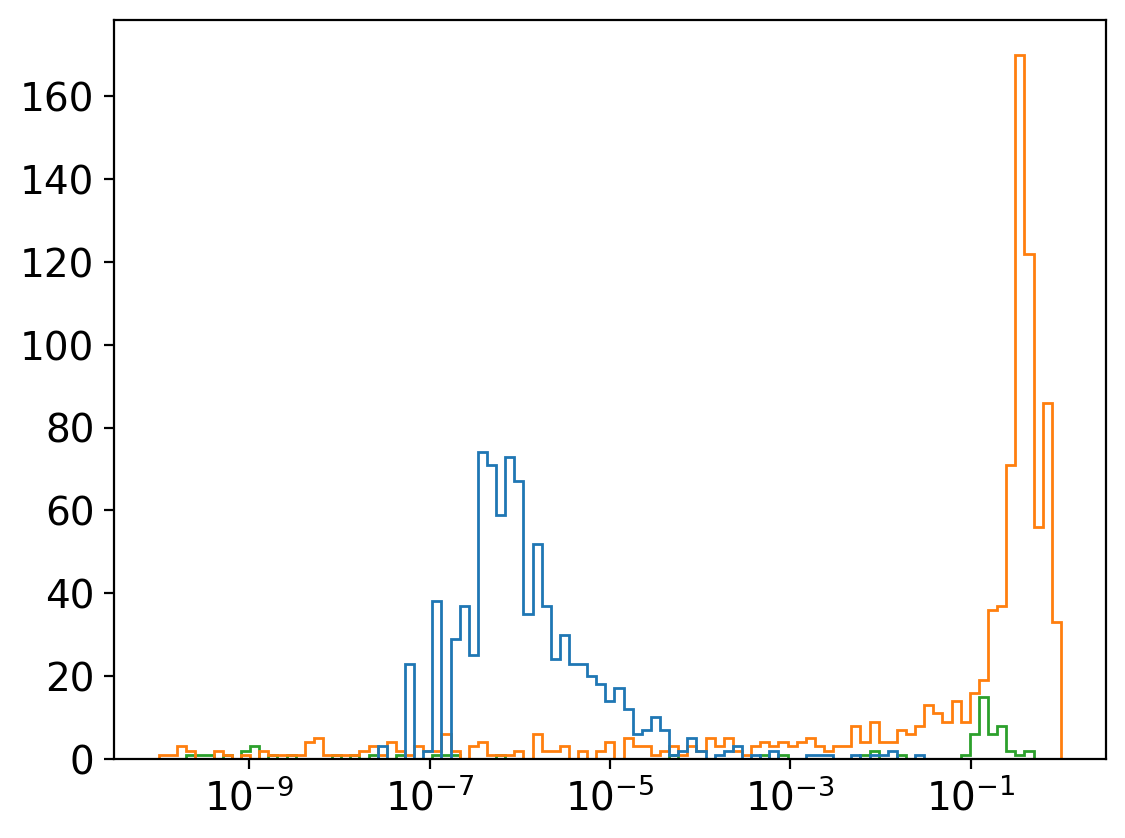

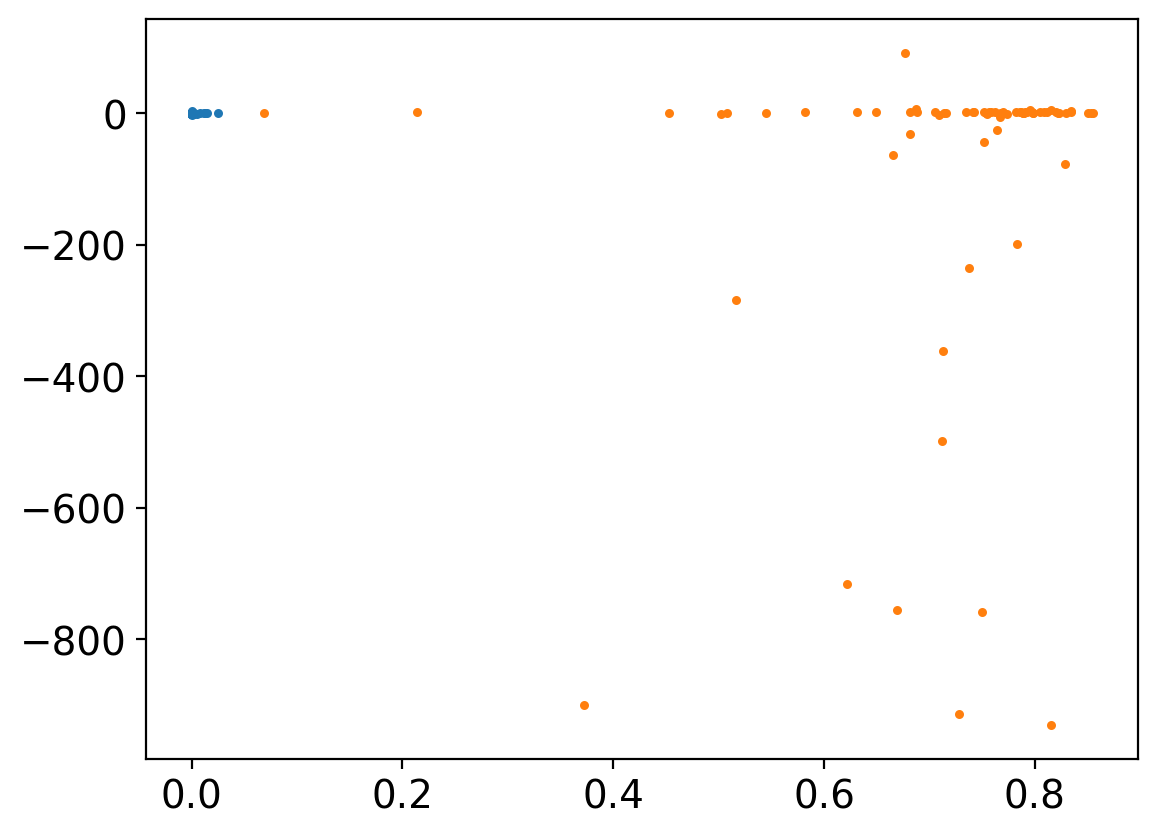

In [384]:
plt.hist(leftover.T, bins=np.logspace(-10, 0, 100), range=(0, 1), histtype='step', label='Leftover probability')
plt.xscale('log')

plt.figure()
for i in range(1, 3):
    plt.scatter(leftover[i-1, :], tick_avg[i, :] - average_measured[:, i], s=5, label=f'Retrigger {i}')


[548.78784 867.01086   0.     ]
[0.         0.52875865 1.        ]
Guess no-hit probability: 1.0
Measured no-hit probability: 0.98800004
Measured avg adc: 81.90088
Guess avg adc: 74.365616
Guess time tick: 0.0
Measured time tick: 900.1667


/var/folders/_d/sfp1ctxj3g13373lj9lb38q80000gn/T/ipykernel_14789/1739062464.py:35: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


(array([0., 0., 0., ..., 0., 0., 0.], shape=(2000,)),
 array([0.000e+00, 1.000e+00, 2.000e+00, ..., 1.998e+03, 1.999e+03,
        2.000e+03], shape=(2001,)),
 [<matplotlib.patches.Polygon at 0x3a272fd90>])

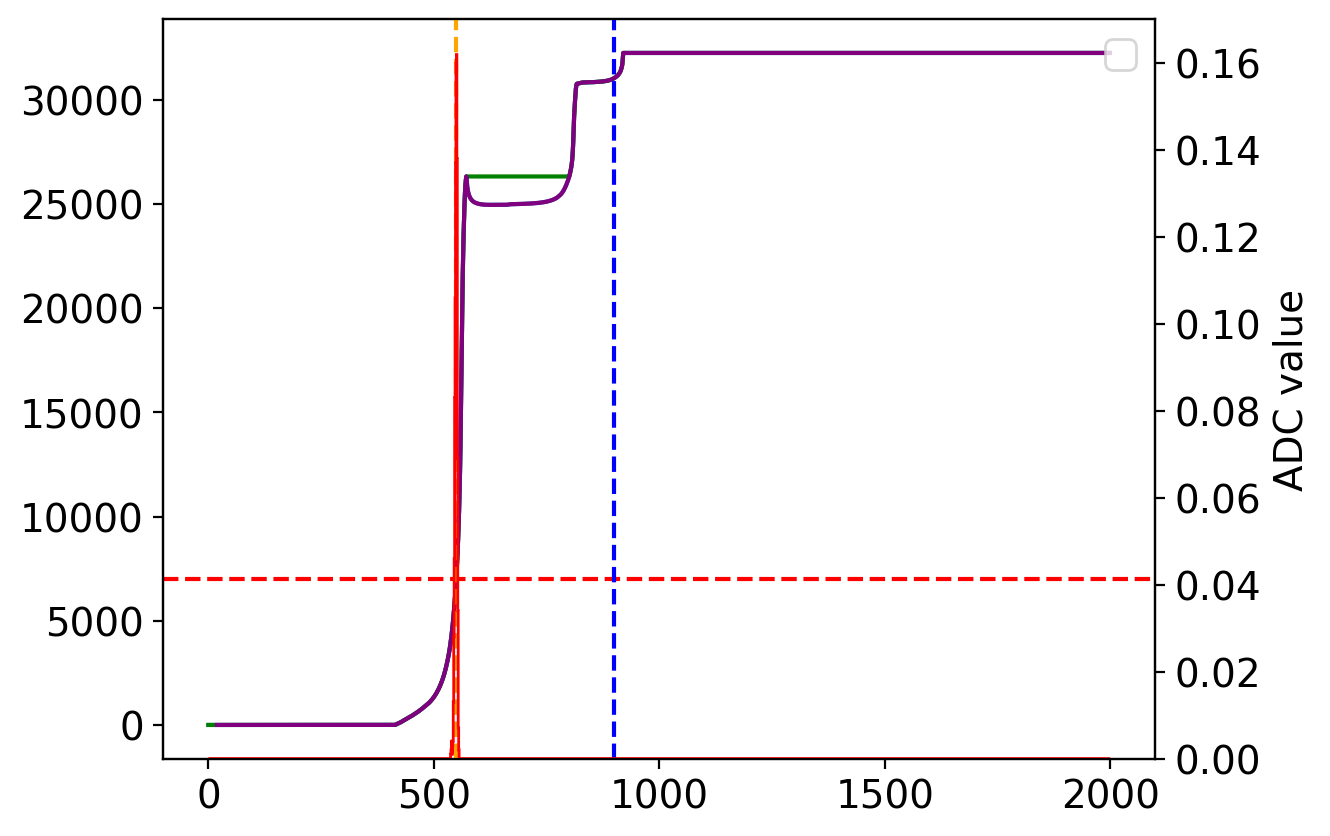

In [359]:
# iplot = 81 #1018 81 289
iplot = 61 #1018 81 289
hitidx = 2

plt.figure()
# q_sum = (wfs_filtered[:, 1:]*ref_params.t_sampling).cumsum(axis=-1)
plt.plot(q_sum[iplot], label='Waveform')
signal = jnp.frompyfunc(jnp.maximum, 2, 1, identity=0).accumulate(q_sum, axis=-1)
plt.plot(signal[iplot], label='Signal', color='green')
plt.axhline(ref_params.DISCRIMINATION_THRESHOLD, color='r', linestyle='--', label='Discrimination threshold')
# plt.plot(average_measured_adc[:, 0], label='Average measured ADC', color='blue')

sigma = ref_params.RESET_NOISE_CHARGE  # Found out that only considering the reset noise was sufficient
interval = round((3 * ref_params.CLOCK_CYCLE + ref_params.ADC_HOLD_DELAY * ref_params.CLOCK_CYCLE) / ref_params.t_sampling)
shifted_ticks = jnp.arange(q_sum.shape[1] - 1) + interval + 1
shifted_ticks = jnp.clip(shifted_ticks, 0, q_sum.shape[1] - 1)
esperance_value = q_sum[iplot, shifted_ticks] #+ sigma*0.5*(1 + erf((q_sum[iplot, :] - ref_params.DISCRIMINATION_THRESHOLD)/(jnp.sqrt(2)*sigma)))/(1 + erf(-(ref_params.DISCRIMINATION_THRESHOLD - q_sum[iplot, :])/(jnp.sqrt(2)*sigma)) + 1e-5)
esperance_value = q_sum[:, shifted_ticks] + sigma*(normpdf.pdf(q_sum[:, :-1], loc=ref_params.DISCRIMINATION_THRESHOLD, scale=sigma) - normpdf.pdf(q_sum[:, 1:], loc=ref_params.DISCRIMINATION_THRESHOLD, scale=sigma))/(erf((signal[:, 1:] - ref_params.DISCRIMINATION_THRESHOLD)/(jnp.sqrt(2)*sigma)) - erf((signal[:, :-1] - ref_params.DISCRIMINATION_THRESHOLD)/(jnp.sqrt(2)*sigma)) + 1e-5)

plt.plot(shifted_ticks, esperance_value[iplot], label='Esperance value', color='purple')

ax2 = plt.gca().twinx()


# prob_charge_pass = jnp.clip((1 + erf(-(ref_params.DISCRIMINATION_THRESHOLD - q_sum[iplot, shifted_ticks])/(jnp.sqrt(2)*sigma))) / (1 + erf(-(ref_params.DISCRIMINATION_THRESHOLD - q_sum[iplot, :])/(jnp.sqrt(2)*sigma)) + 1e-5), 0, 1)

# ax2.plot(guess[0, iplot, :]*prob_charge_pass[1:], label='Guess', color='purple' )
# ax2.plot(guess[0, iplot, :], label='Guess', color='orange' )
# ax2.plot(guess[0, iplot, :].cumsum(), label='Guess', color='red' )

plt.xlabel('Time tick')
plt.ylabel('ADC value')
# plt.xlim(680, 820)
# plt.xlim(0, 90)
plt.legend()
print(tick_avg[:, iplot])
print(no_hit_prob[:, iplot])
plt.axvline(tick_avg[0, iplot], color='orange', linestyle='--', label='Guess tick')
plt.axvline(average_measured[iplot, hitidx], color='blue', linestyle='--', label='Measured tick')
sigma = ref_params.RESET_NOISE_CHARGE  # Found out that only considering the reset noise was sufficient
# norm = 0.5*(erf((q_sum[iplot, -1] - ref_params.DISCRIMINATION_THRESHOLD)/(jnp.sqrt(2)*sigma)) - erf((q_sum[iplot, :1] - ref_params.DISCRIMINATION_THRESHOLD)/(jnp.sqrt(2)*sigma)))
# guess_plot = 0.5*(erf((signal[1:] - ref_params.DISCRIMINATION_THRESHOLD)/(jnp.sqrt(2)*sigma)) - erf((signal[:-1] - ref_params.DISCRIMINATION_THRESHOLD)/(jnp.sqrt(2)*sigma)))
# guess_plot = 0.5*(erf((signal[iplot, 1:] - ref_params.DISCRIMINATION_THRESHOLD)/(jnp.sqrt(2)*sigma)) - erf((signal[iplot, :-1] - ref_params.DISCRIMINATION_THRESHOLD)/(jnp.sqrt(2)*sigma)))



print("Guess no-hit probability:", no_hit_prob[hitidx, iplot])
print("Measured no-hit probability:", measured_no_hit_prob[iplot, hitidx])
# plt.plot(guess_plot, label='Guess (plot)', color='purple')
print("Measured avg adc:", average_measured_adc[iplot, hitidx])
print("Guess avg adc:", adc_avg[hitidx, iplot])
print("Guess time tick:", tick_avg[hitidx, iplot])
print("Measured time tick:", average_measured[iplot, hitidx])

plt.hist(ticks_filtered[:, iplot, 0][mask[:, iplot, 0]], bins=np.linspace(0, 2000, 2001), histtype='step', label='Measured ticks', color='r', density=True)

# shifted_ticks2 = jnp.clip(shifted_ticks + 1, 0, q_sum_loc.shape[1] - 1)




# plt.plot(shifted_ticks, prob_charge_pass, label='Probability of charge passing', color='purple')
# print((prob_charge_pass[..., :-1]*guess[0, iplot, :]).sum())


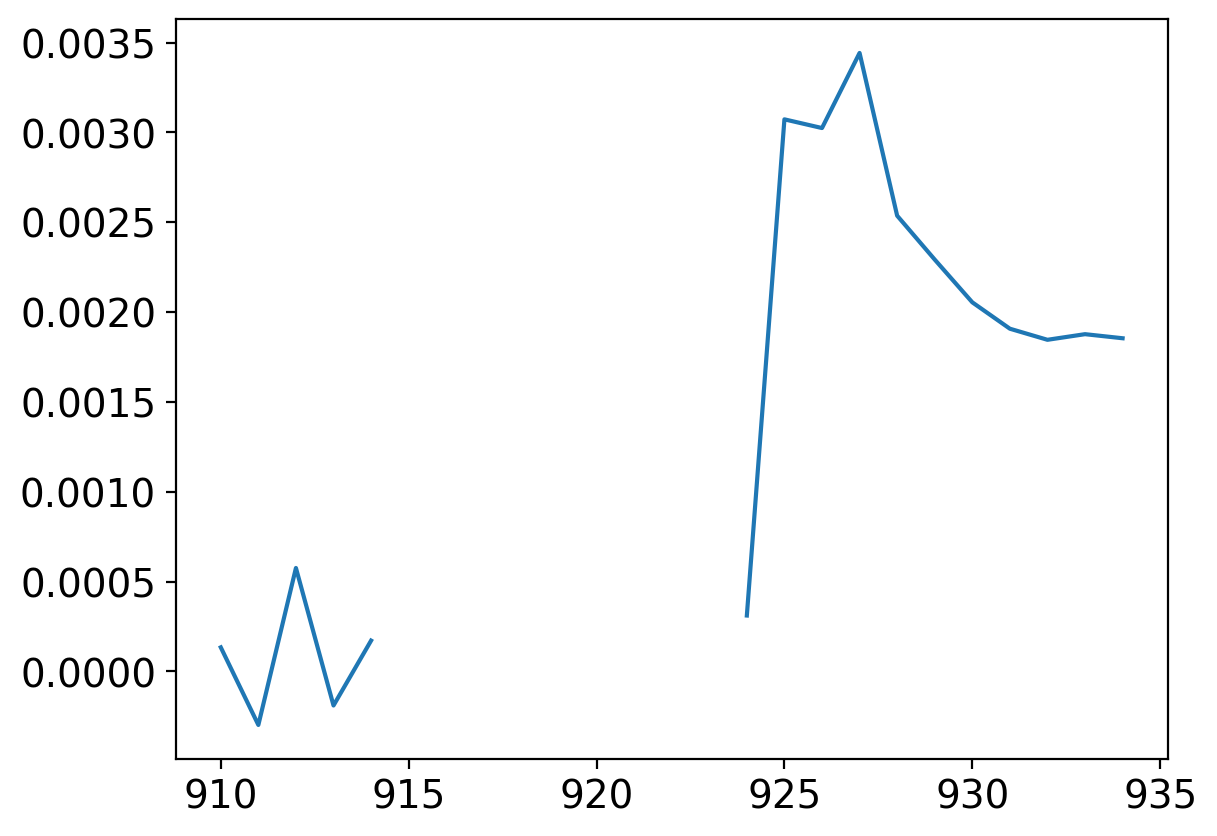

In [202]:
iplot = 550
plt.plot((normpdf.pdf(signal[iplot, 1:], loc=ref_params.DISCRIMINATION_THRESHOLD, scale=sigma) - normpdf.pdf(signal[iplot, :-1], loc=ref_params.DISCRIMINATION_THRESHOLD, scale=sigma))/(erf((signal[iplot, 1:] - ref_params.DISCRIMINATION_THRESHOLD)/(jnp.sqrt(2)*sigma)) - erf((signal[iplot, :-1] - ref_params.DISCRIMINATION_THRESHOLD)/(jnp.sqrt(2)*sigma))))

In [492]:
digitize(ref_params, ref_params.DISCRIMINATION_THRESHOLD)

Array(81.44862, dtype=float32, weak_type=True)

In [455]:
guess.shape

(10, 1128, 1999)

In [357]:
jnp.argsort(adc_avg[2, :].flatten() - average_measured_adc[:, 2].flatten())
# jnp.sort(adc_avg[0, :].flatten() - average_measured_adc[:, 0].flatten())

Array([  71,  963,   61, ..., 1078, 1079, 1080], dtype=int32)

(1128, 1)

In [363]:
tick_avg[0, 1028]

Array(nan, dtype=float32)

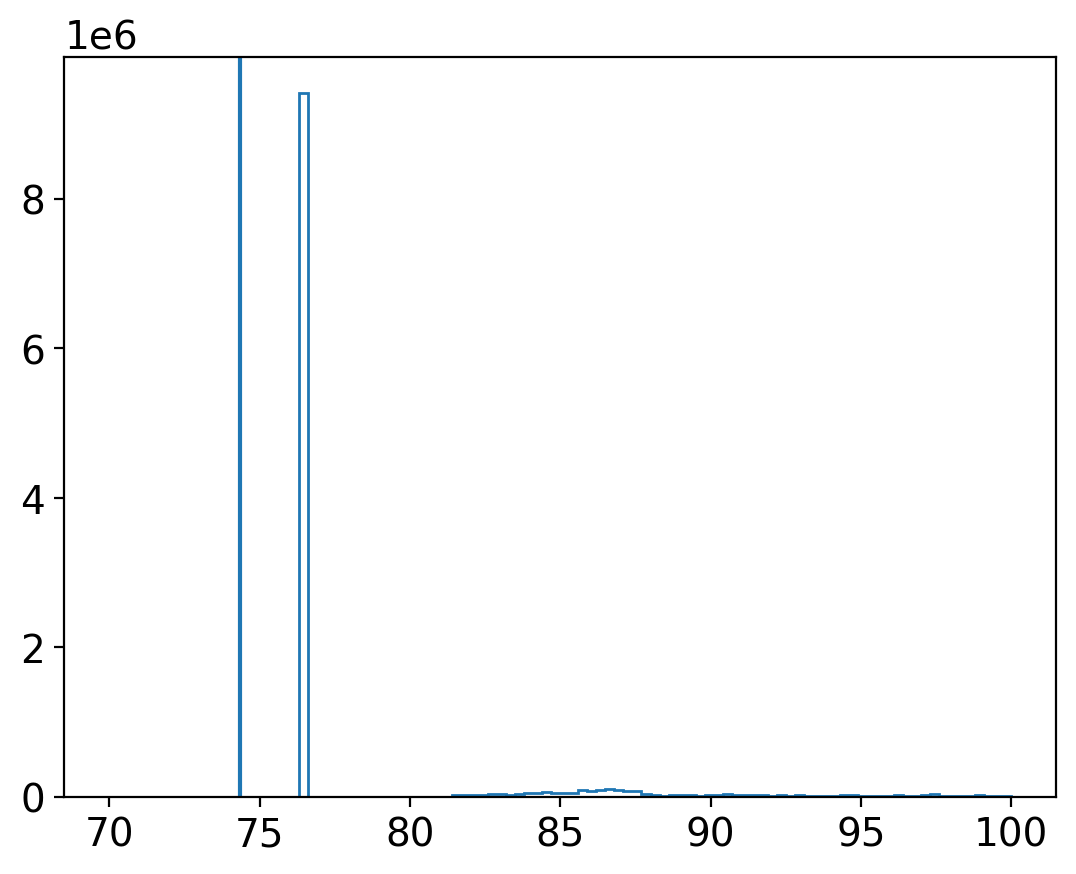

In [284]:
plt.hist(filtered.flatten(), bins=100, range=(70, 100), histtype='step', label='Filtered ADCs')
plt.axvline(74.3567)

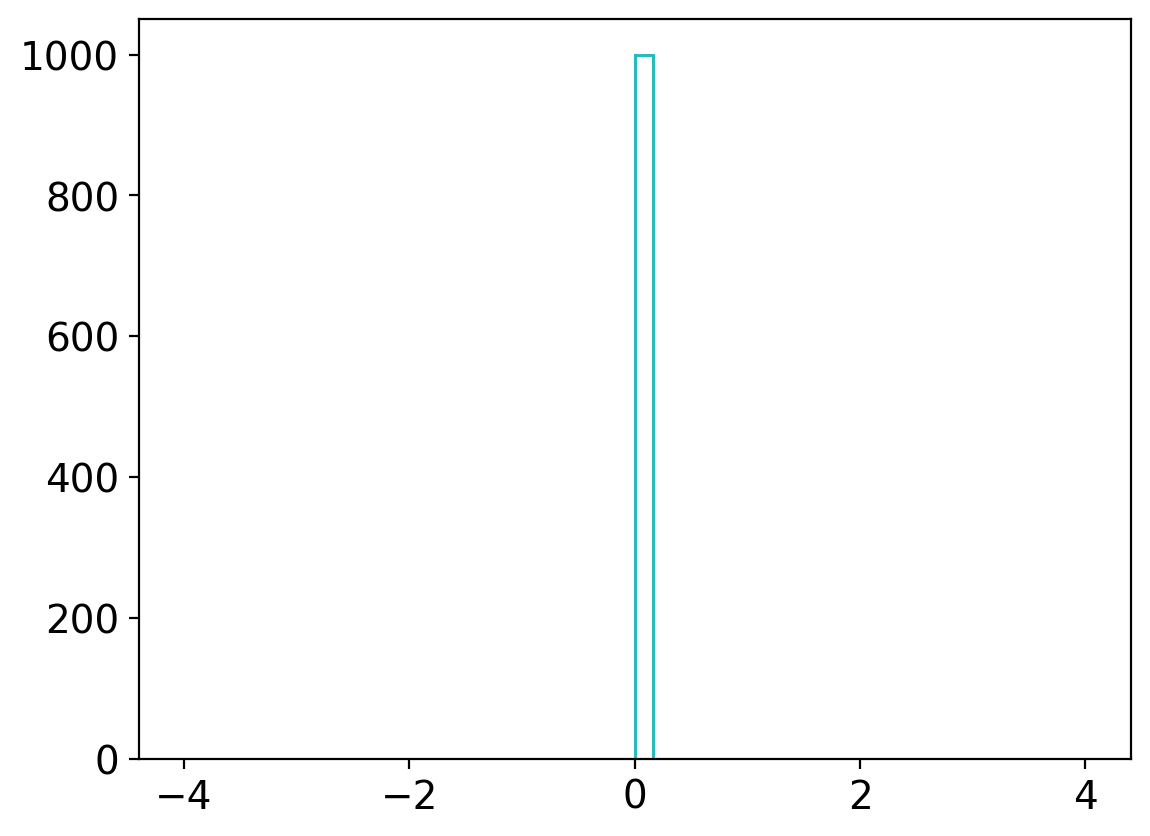

In [287]:
fig, ax = plt.subplots(1, 1)

for i in range(10):
    ax.hist(filtered[:, i, 0].flatten() - filtered[:, i, 0].flatten().mean(), bins=50, range=(-4, 4), histtype='step', label=f'pixel {i}')
    # ax.axvline(filtered_nonoise[i, 0] - filtered[:, i, 0].flatten().mean(), color='k', linestyle='--')
# plt.hist(filtered[:, :, 0].flatten(), bins=100, range=(75, 140));

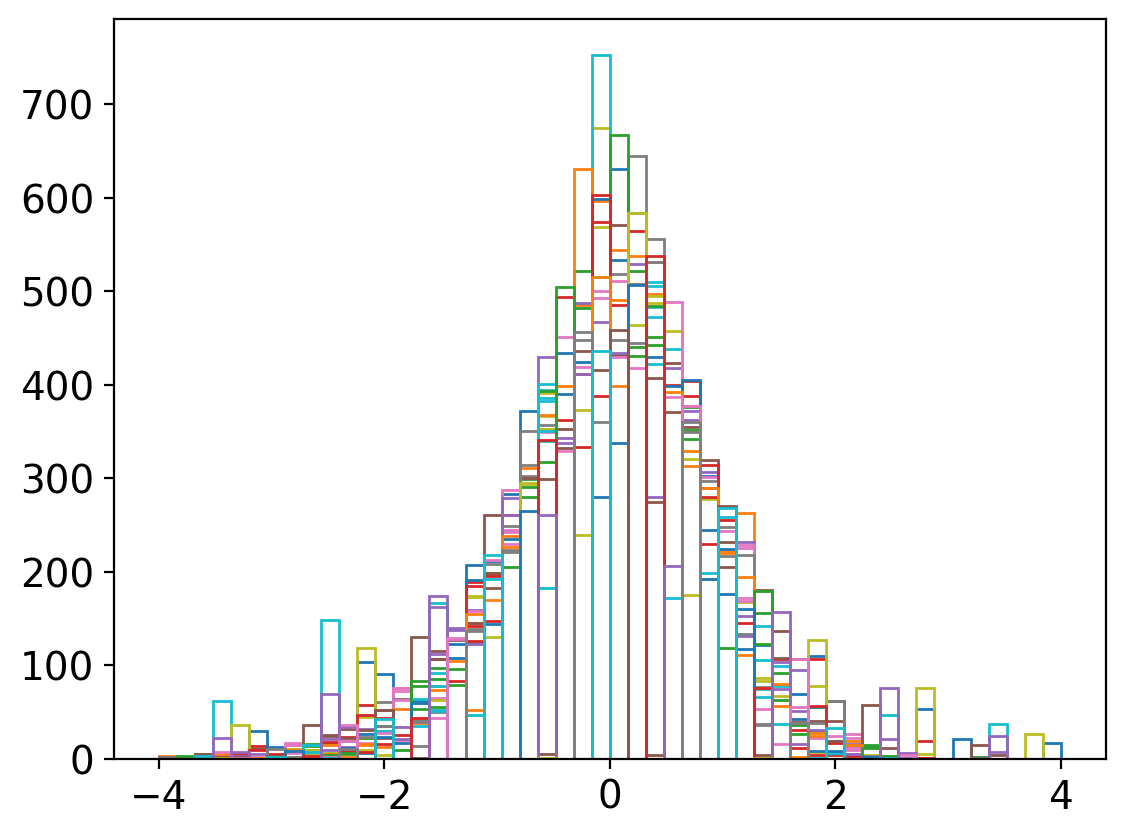

In [7]:
fig, ax = plt.subplots(1, 1)

for i in range(100):
    ax.hist(ticks_filtered[:, i, 0].flatten() - ticks_filtered[:, i, 0].flatten().mean(), bins=50, range=(-4, 4), histtype='step', label=f'pixel {i}')
    # ax.axvline(filtered_nonoise[i, 0] - filtered[:, i, 0].flatten().mean(), color='k', linestyle='--')
# plt.hist(filtered[:, :, 0].flatten(), bins=100, range=(75, 140));

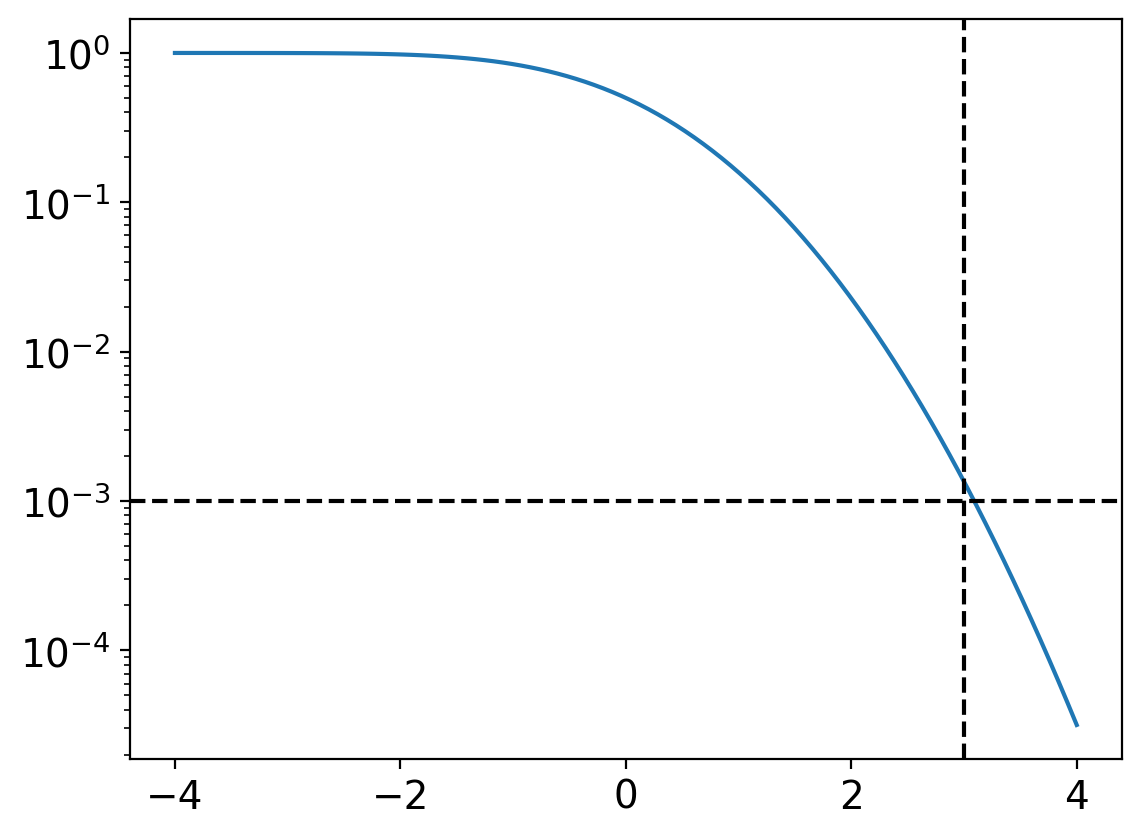

In [7]:
from scipy.special import erf

x = np.linspace(-4, 4, 100)
y = 0.5 * (1 - erf(x / np.sqrt(2)))
plt.plot(x, y)
plt.yscale('log')
plt.axhline(1e-3, color='k', linestyle='--')
plt.axvline(3, color='k', linestyle='--')

1029.5630140987
(1128,)
(1128, 2000)
(1128, 1000, 10)
(1128,)
(1128, 10)
(1010, 60)
[7.60661471e-05 1.00229693e-04 1.63388659e-04 2.47258198e-04
 2.84812649e-04 4.24598552e-04 6.50588379e-04 8.89839008e-04
 1.23898164e-03 1.53061270e-03 2.46013701e-03 3.25876409e-03
 4.61224090e-03 6.73593277e-03 9.97129302e-03 1.38850845e-02
 1.92063173e-02 2.74927142e-02 3.81187575e-02 5.36189364e-02
 6.89480071e-02 8.19051971e-02 9.06366965e-02 9.47999792e-02
 9.30552510e-02 8.48719818e-02 7.16540334e-02 5.65917632e-02
 4.08414623e-02 2.76680008e-02 1.85433504e-02 1.23880878e-02
 8.94889734e-03 7.23528339e-03 7.33467649e-03 9.25710742e-03
 1.01409467e-02 8.94260239e-03 6.27058232e-03 3.95613649e-03
 1.95048786e-03 1.35490934e-03 1.66494201e-03 1.18471467e-03
 1.27223039e-03 8.51676583e-04 5.56972372e-04 3.75528413e-04
 3.08955626e-04 2.79844865e-04 1.79346130e-04 3.91129692e-04
 1.36529780e-04 8.87101439e-05 7.03745947e-05 5.93897734e-05
 3.41636361e-05 8.17151424e-05 9.15179589e-05 1.10264709e-04]


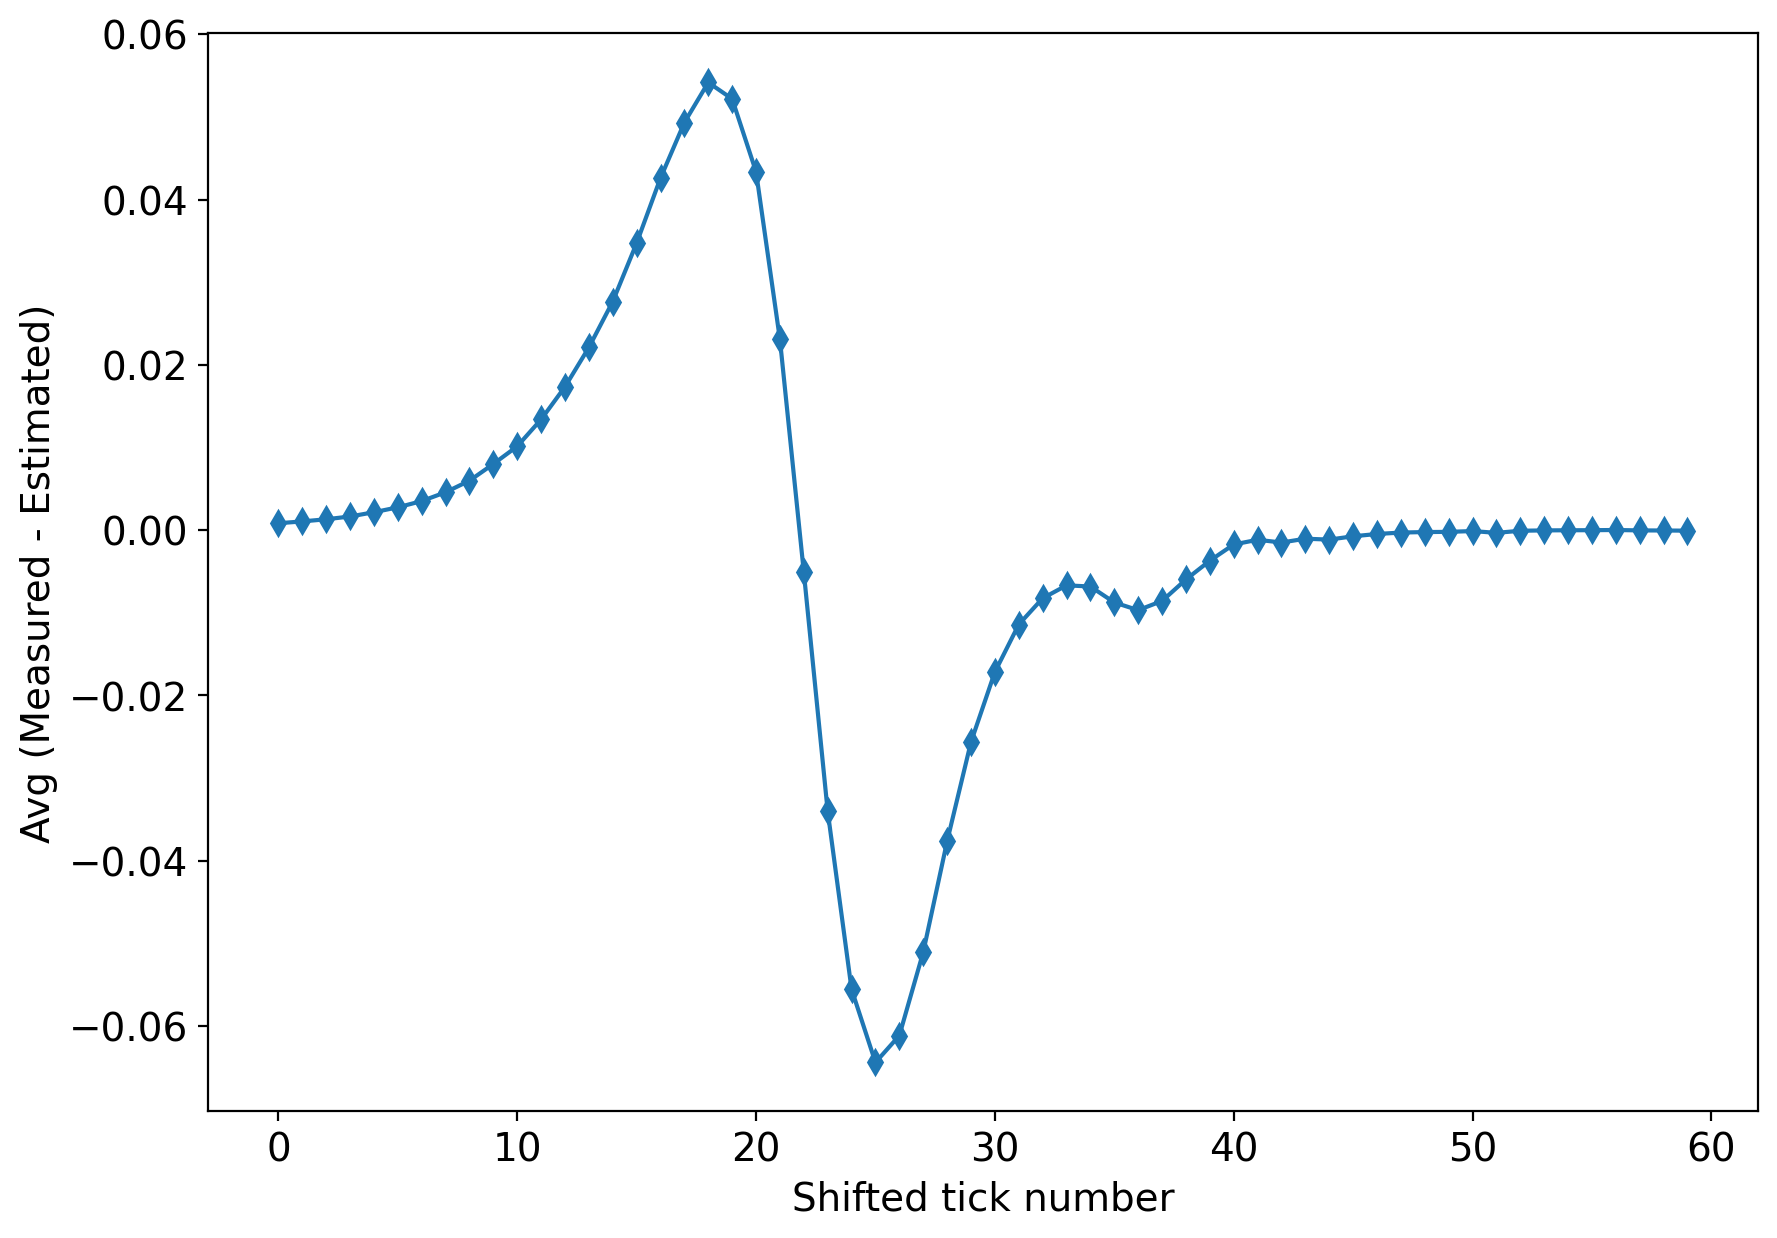

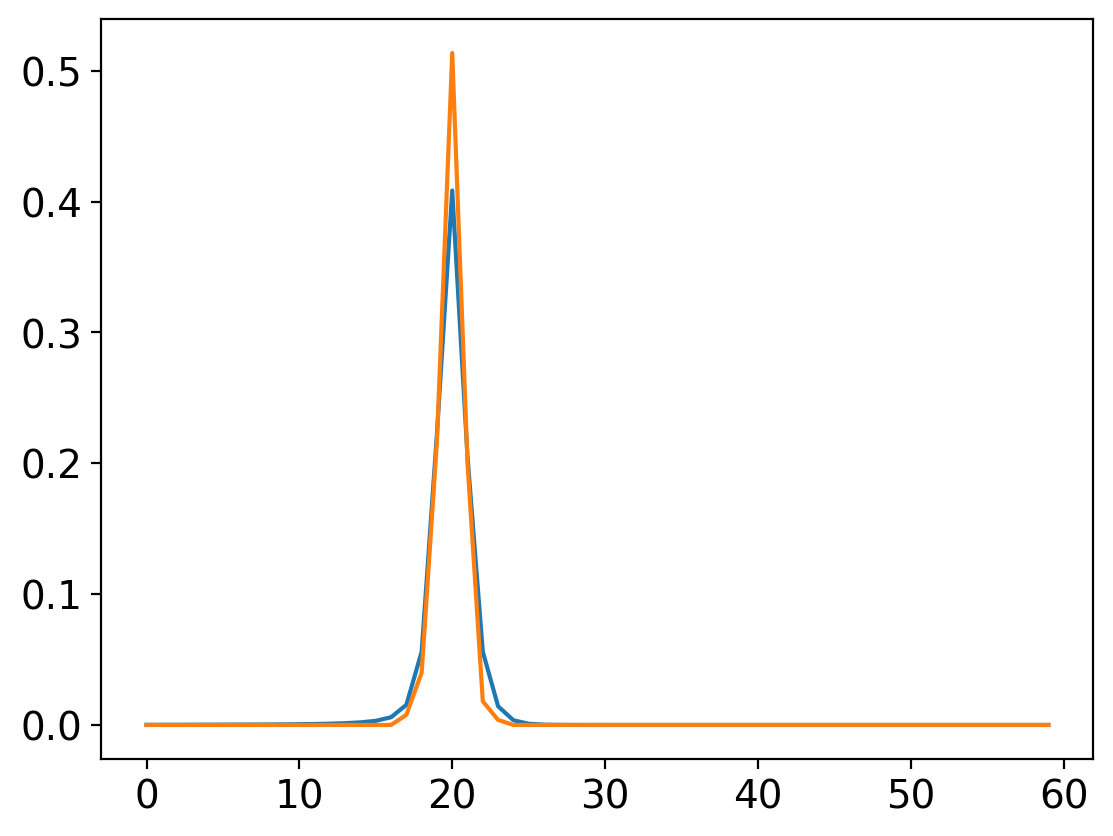

In [307]:
sigma = np.sqrt(ref_params.UNCORRELATED_NOISE_CHARGE**2 + ref_params.RESET_NOISE_CHARGE**2)
# sigma = 1
print(sigma)


plt.figure(figsize=(10, 7))

# i = 127

q_sum = np.cumsum(wfs_filtered[:, 1:], axis=1)*ref_params.t_sampling

# for i in range(0,1):
x = np.arange(1, wfs_filtered.shape[1])
lower_term = 0.5*(1 + erf((ref_params.DISCRIMINATION_THRESHOLD - q_sum)/(np.sqrt(2)*sigma)))
upper_term = 1-lower_term
lower_term = np.column_stack([np.ones((q_sum.shape[0])), np.cumprod(lower_term, axis=1)])
upper_term = np.column_stack([upper_term, np.ones((q_sum.shape[0]))])
guess = (upper_term[:, 1:]*lower_term[:, 1:])
# ax = plt.gca()
xmax = jnp.argmax(upper_term[:, 1:] * lower_term[:, 1:], axis=1)
xl = xmax - 20
xh = xmax + 40

# Print shapes for debugging
print(xl.shape)
print(q_sum.shape)

# Initialize an empty list to store selected slices
selected_slices = []


# Iterate over each element in the batch
for i in range(xl.shape[0]):
    # Extract the slice for the i-th element
    selected_slice = guess[i, xl[i]:xh[i]]
    selected_slices.append(selected_slice)

new_mask = [len(L) == 60 for L in selected_slices]
selected_slices = [L for L in selected_slices if len(L) == 60]

# Stack the selected slices along a new axis
selected = jnp.stack(selected_slices, axis=0)
# plt.plot(selected.T, 'd-', label=f'pixel {i}')
print(ticks_filtered[:, :, :].swapaxes(0, 1).shape)
print(xmax.shape)
for data in ticks_filtered:
    print(data.shape)
    break
histograms = np.vstack([np.histogram((data[:, 0]- xmax[i]), bins=np.linspace(-20, 40, 61), density=True)[0] for i, data in enumerate(ticks_filtered.swapaxes(0, 1))])
histograms = histograms[np.array(new_mask), :]
print(histograms.shape)

plt.plot(np.mean((selected -histograms), axis=0), marker='d')
# ax2 = plt.gca().twinx()
# ax2.plot(np.mean((histograms), axis=0), marker='d', color='r')
print(np.mean(histograms, axis=0))

plt.ylabel("Avg (Measured - Estimated)")
plt.xlabel('Shifted tick number')

iplot = 931

plt.figure()
plt.plot(selected[iplot])
plt.plot(histograms[iplot])

# plt.hist(jnp.floor(ticks_filtered[:, :, 0]), bins=np.arange(xl, xh), density=True, label='Measured distrib')

# ax.set_xlim(xl, xh)
# # ax.set_ylim(-1000, 10000)
# ax2 = ax.twinx()
# ax2.plot(lower_term[1:].T, 'd-', color='r', label='P(no trigger before)')
# ax2.plot(upper_term[1:].T, 'd-', label=f'P(triggered)', color='g')
# ax2.plot((upper_term[1:]*lower_term[1:]).T, 'd-', label=f'P(first trigger)', color='k')
# ax2.legend(loc='center left')
# ax.axhline(0, color='k', linestyle='--')
    # plt.fill_between(x, -ref_params.UNCORRELATED_NOISE_CHARGE*np.sqrt(x), ref_params.UNCORRELATED_NOISE_CHARGE*np.sqrt(x), alpha=0.2, color='k')
# (upper_term*lower_term[:-1])[525:535]

# plt.figure()
# plt.hist(jnp.floor(ticks_filtered[:, i, 0]), bins=np.arange(xl, xh), density=True, label='Measured distrib')
# plt.plot(np.arange(xl, xh) + 0.5, (upper_term[1:]*lower_term[1:])[xl:xh], 'd-', color='r', label='Predicted distrib')
# plt.legend()

In [308]:
sigma = np.sqrt(ref_params.UNCORRELATED_NOISE_CHARGE**2 + ref_params.RESET_NOISE_CHARGE**2)

def phi(x):
    return 0.5 * (1 - erf(x / np.sqrt(2)))

def get_noise_probability_correlated(q_sum, sigma):
    guess = 0.5*(erf((q_sum[:, 1:] - ref_params.DISCRIMINATION_THRESHOLD)/(np.sqrt(2)*sigma)) - erf((q_sum[:, :-1] - ref_params.DISCRIMINATION_THRESHOLD)/(np.sqrt(2)*sigma)))
    norm = 0.5*(erf((q_sum[:, -1] - ref_params.DISCRIMINATION_THRESHOLD)/(np.sqrt(2)*sigma)) - erf((q_sum[:, 1] - ref_params.DISCRIMINATION_THRESHOLD)/(np.sqrt(2)*sigma)))
    # guess = guess / norm[:, None]
    no_hit_prob = 1 - norm
    # prob = 1 - 0.5*(1 + erf((q_sum - ref_params.DISCRIMINATION_THRESHOLD)/(np.sqrt(2)*sigma)))
    # no_hit_prob = np.prod(prob, axis=1)
    return guess, no_hit_prob


def get_noise_probability_uncorrelated(q_sum, sigma):
    lower_term = 0.5*(1 + erf((ref_params.DISCRIMINATION_THRESHOLD - q_sum)/(np.sqrt(2)*sigma)))
    upper_term = 1-lower_term
    lower_term = np.column_stack([np.ones((q_sum.shape[0])), np.cumprod(lower_term, axis=1)])
    upper_term = np.column_stack([upper_term, np.ones((q_sum.shape[0]))])
    guess = (upper_term[:, 1:]*lower_term[:, 1:])
    norm = np.sum(guess, axis=1)
    no_hit_prob = 1 - norm
    return guess, no_hit_prob


plt.figure(figsize=(10, 7))

# i = 127

q_sum = np.cumsum(wfs_filtered[:, 1:], axis=1)*ref_params.t_sampling


guess, no_hit_prob = get_noise_probability_correlated(q_sum, sigma)

# Initialize an empty list to store selected slices
selected_slices = []
window_size = 50


# Iterate over each element in the batch
for i in range(xl.shape[0]):
    # Extract the slice for the i-th element
    selected_slice = guess[i, xl[i]:xh[i]]
    selected_slices.append(selected_slice)
print([len(L) for L in selected_slices])
new_mask = [len(L) == 2*window_size for L in selected_slices]
selected_slices = [L for L in selected_slices if len(L) == 2*window_size]

# Stack the selected slices along a new axis
selected = jnp.stack(selected_slices, axis=0)

for data in ticks_filtered:
    print(data.shape)
    break
histograms = np.vstack([np.histogram((data[:, 0]- xmax[i]), bins=np.linspace(-window_size, window_size, 2*window_size+1), density=True)[0] for i, data in enumerate(ticks_filtered.swapaxes(0, 1))])
histograms = histograms[np.array(new_mask), :]


plt.plot(np.mean((selected -histograms), axis=0), marker='d')

plt.ylabel("Avg (Measured - Estimated)")
plt.xlabel('Shifted tick number')

iplot = 3
# iplot = 32

plt.figure()
plt.plot(selected[iplot])
plt.plot(histograms[iplot])

chi2 = np.sum((selected - histograms)**2, axis=1)

print(np.argsort(chi2, )[::-1])

plt.figure()
plt.hist(np.sqrt(np.sum((selected-histograms)**2, axis=1)), bins=100, histtype='step', label='Chi2 distribution')

average_guess = np.sum(guess[iplot, :]*np.arange(guess.shape[1])) + 0.5# + no_hit_prob * (guess.shape[1] - 1)
first_ticks = ticks_filtered[:, :, 0]
average_measured = np.average(first_ticks[:, iplot], weights=(first_ticks[:, iplot] < 1998))
print("Average guess:", average_guess)
print("Average measured:", average_measured)
print(first_ticks[:, iplot][first_ticks[:, iplot] < 1998])

[60, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 60, 60, 60, 60, 20, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 20, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 20, 60, 20, 60, 20, 60, 20, 60, 20, 60, 20, 60, 20, 60, 20, 60, 20, 60, 20, 60, 60, 60, 60, 20, 60, 20, 60, 20, 60, 20, 60, 60, 60, 20, 60, 20, 60, 20, 60, 20, 20, 60, 20, 60, 20, 60, 20, 60, 20, 60, 20, 60, 20, 60, 20, 60, 20, 60, 20, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 20, 60, 60, 60, 60, 60, 20, 0, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 

ValueError: Need at least one array to stack.

<Figure size 1000x700 with 0 Axes>

ValueError: x and y must be the same size

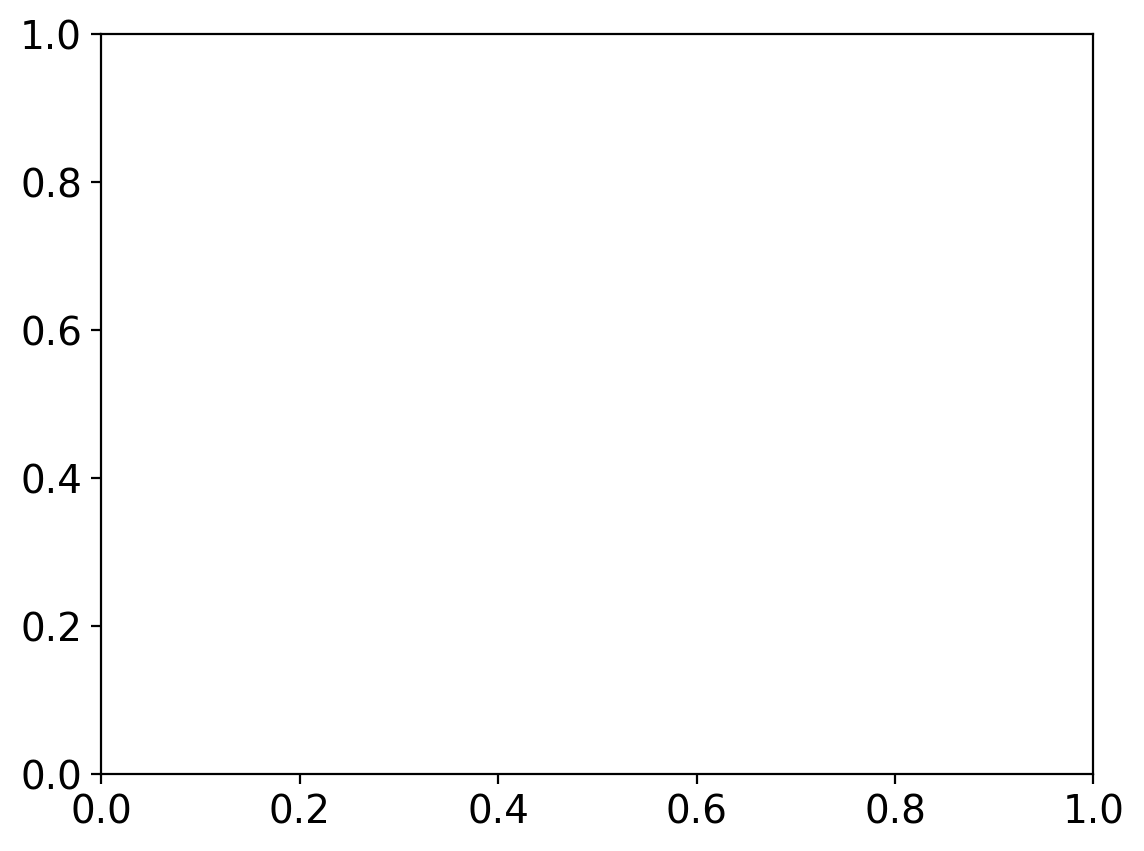

In [264]:
# sigma = 0

sigma = np.sqrt(ref_params.UNCORRELATED_NOISE_CHARGE**2 + ref_params.RESET_NOISE_CHARGE**2)

guess, no_hit_prob = get_noise_probability_correlated(q_sum, ref_params.RESET_NOISE_CHARGE)
# guess, no_hit_prob = get_noise_probability_correlated(q_sum, sigma)
guess2, no_hit_prob2 = get_noise_probability_correlated(q_sum, sigma)

average_guess = np.sum(guess/ (1-no_hit_prob[:, None])*np.arange(guess.shape[1]), axis=1) + 0.5# + no_hit_prob * (guess.shape[1] - 1)
first_ticks = ticks_filtered[:, :, 0]
average_measured = np.average(first_ticks, axis=0, weights=(first_ticks < 1998))
average_guess2 = np.sum(guess2/ (1-no_hit_prob2[:, None])*np.arange(guess2.shape[1]), axis=1) + 0.5# + no_hit_prob * (guess.shape[1] - 1)
# print(jnp.argsort(abs(average_guess - average_measured))[::-1])
plt.scatter(average_measured, average_guess, s=5)
plt.scatter(average_measured, average_guess2, s=5)
plt.plot([0, 1000], [0, 1000], color='r', linestyle='--')
plt.xlabel('Average measured tick number')
plt.ylabel('Average guess tick number')



plt.figure()
plt.hist(average_guess - average_measured, bins=100, range=(-1, 1), histtype='step', label='Average guess - measured');
plt.hist(average_guess2 - average_measured, bins=100, range=(-1, 1), histtype='step', label='Average guess2 - measured');
plt.xlabel('Average guess - measured tick number')
plt.ylabel('Counts')
print("Std of average guess - measured:", np.std(average_guess - average_measured))

plt.figure()
plt.scatter(q_sum[:,-1], average_guess - average_measured, s=5);
plt.scatter(q_sum[:,-1], average_guess2 - average_measured, s=5);
plt.axhline(0, color='k', linestyle='--')
plt.xscale('log')
# plt.yscale('symlog')
plt.xlabel('Last tick number')
plt.ylabel('Average guess - measured tick number')
plt.axvline(ref_params.DISCRIMINATION_THRESHOLD, color='k', linestyle='--', label='Discrimination threshold')

interval = round((3 * ref_params.CLOCK_CYCLE + ref_params.ADC_HOLD_DELAY * ref_params.CLOCK_CYCLE) / ref_params.t_sampling)

shifted_ticks = np.clip(np.arange(guess.shape[1]) + interval + 1, 0, q_sum.shape[1] - 1)
average_guess_adc = np.sum(guess*digitize(ref_params, q_sum[:, shifted_ticks]), axis=1) + no_hit_prob*74.3656
shifted_ticks = np.clip(np.arange(guess.shape[1]) + interval + 2, 0, q_sum.shape[1] - 1)
average_guess_adc = 0.5*(np.sum(guess*digitize(ref_params, q_sum[:, shifted_ticks]), axis=1) + no_hit_prob*74.3656 + average_guess_adc)

shifted_ticks2 = np.clip(np.arange(guess2.shape[1]) + interval + 1, 0, q_sum.shape[1] - 1)
average_guess_adc2 = np.sum(guess2*digitize(ref_params, q_sum[:, shifted_ticks2]), axis=1) + no_hit_prob2*74.3656
shifted_ticks2 = np.clip(np.arange(guess2.shape[1]) + interval + 2, 0, q_sum.shape[1] - 1)
average_guess_adc2 = 0.5*(np.sum(guess2*digitize(ref_params, q_sum[:, shifted_ticks2]), axis=1) + no_hit_prob2*74.3656 + average_guess_adc2)

first_adc = filtered[:, :, 0]
average_measured_adc = np.average(first_adc, axis=0, weights=(first_adc > 74.3567))

plt.figure()
plt.scatter(average_measured_adc, average_guess_adc, s=5)
plt.xlabel('Average measured ADC value')
plt.ylabel('Average guess ADC value')

print("Std of average guess - measured ADC:", np.std(average_guess_adc - average_measured_adc))

# average_guess_adc =  np.sum(guess * digitize(ref_params, q_sum[:, shifted_ticks]), axis=1)
# plt.scatter(average_measured_adc, average_guess_adc, s=1)

plt.plot([70, 110], [70, 110], color='k', linestyle='--')
plt.figure()
plt.hist(average_guess_adc - average_measured_adc, bins=100, range=(-3, 3), histtype='step', label='Average guess - measured');
plt.xlabel('Average guess - measured ADC value')
plt.ylabel('Counts')
print(np.argsort(np.abs(average_guess_adc - average_measured_adc))[::-1])
print(average_guess_adc[iplot], average_measured_adc[iplot])

plt.figure()
plt.scatter(average_measured_adc, average_guess_adc - average_measured_adc, s=5)
plt.scatter(average_measured_adc, average_guess_adc2 - average_measured_adc, s=5)

plt.xlabel('Average measured ADC value')
plt.ylabel('Average guess - measured ADC value')

plt.figure()
plt.scatter(np.mean((first_ticks == 1998), axis=0), no_hit_prob, s=5)
plt.scatter(np.mean((first_ticks == 1998), axis=0), no_hit_prob2, s=5)
plt.xlabel('Fraction of no-hit pixels')
plt.ylabel('No-hit probability')
plt.plot([0, 1], [0, 1], color='k', linestyle='--')
plt.xscale('log')
plt.yscale('log')
np.argsort(np.mean((first_ticks == 1998), axis=0))[::-1]

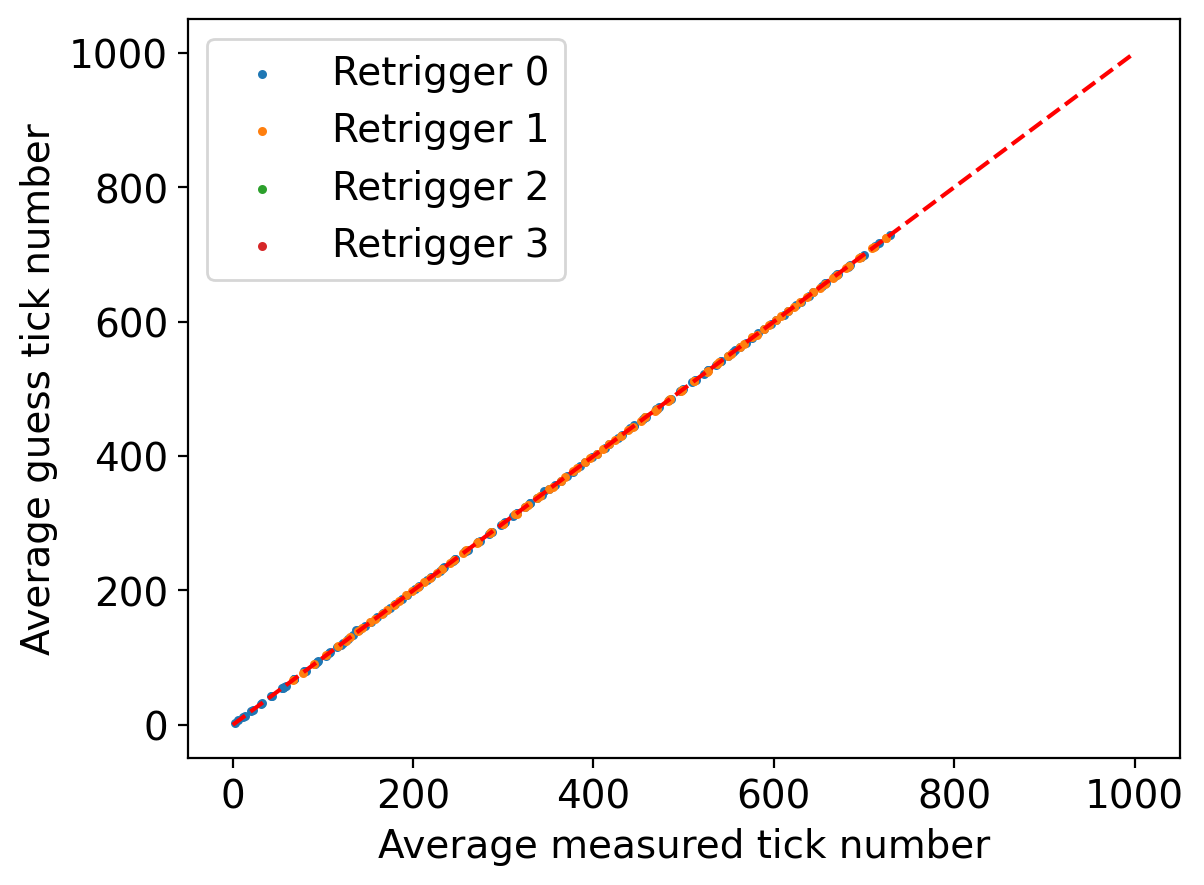

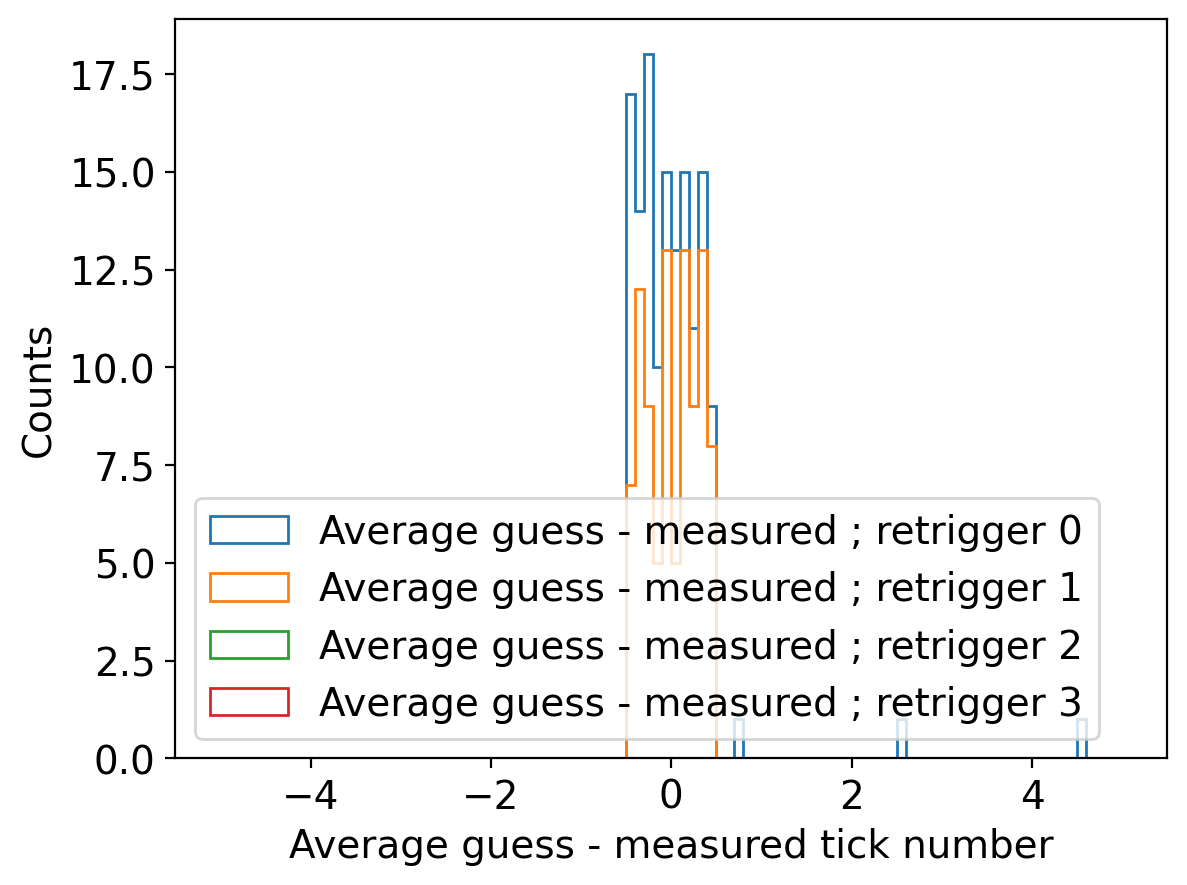

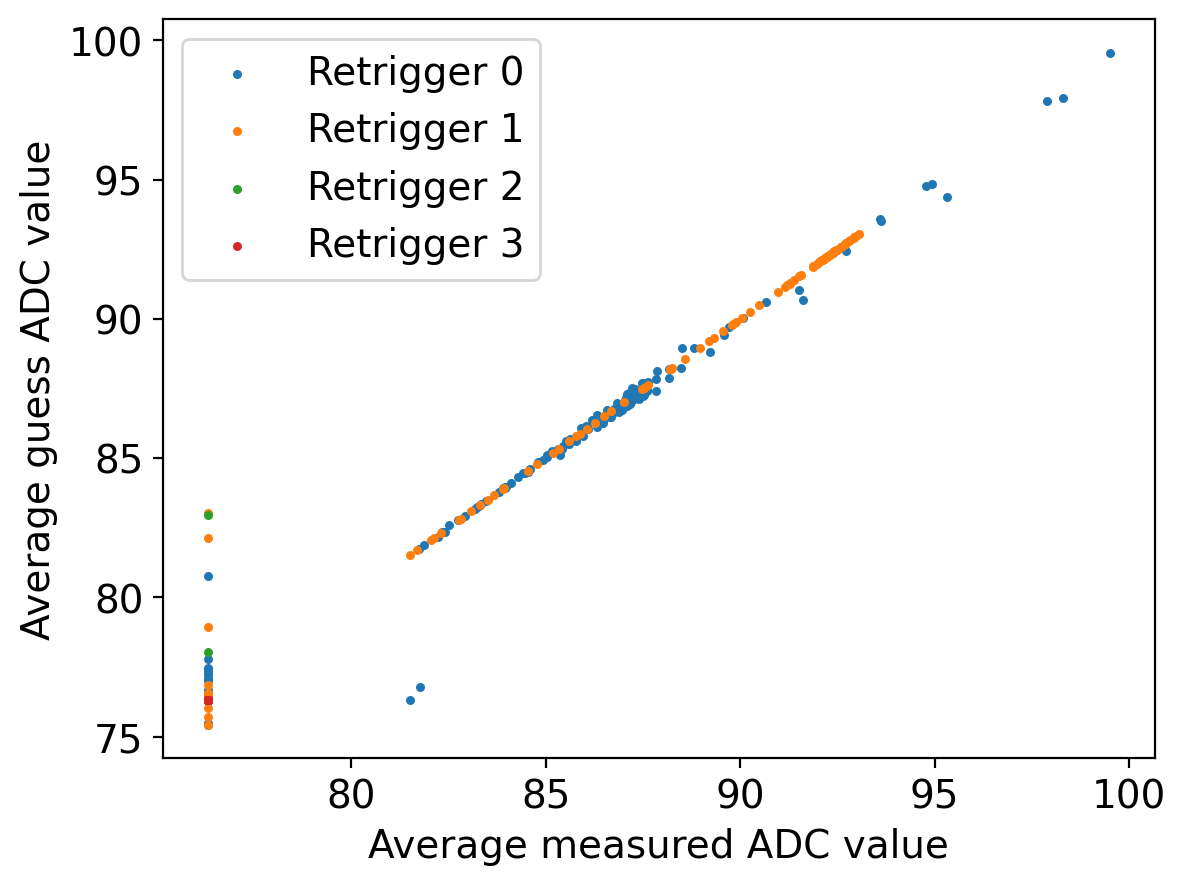

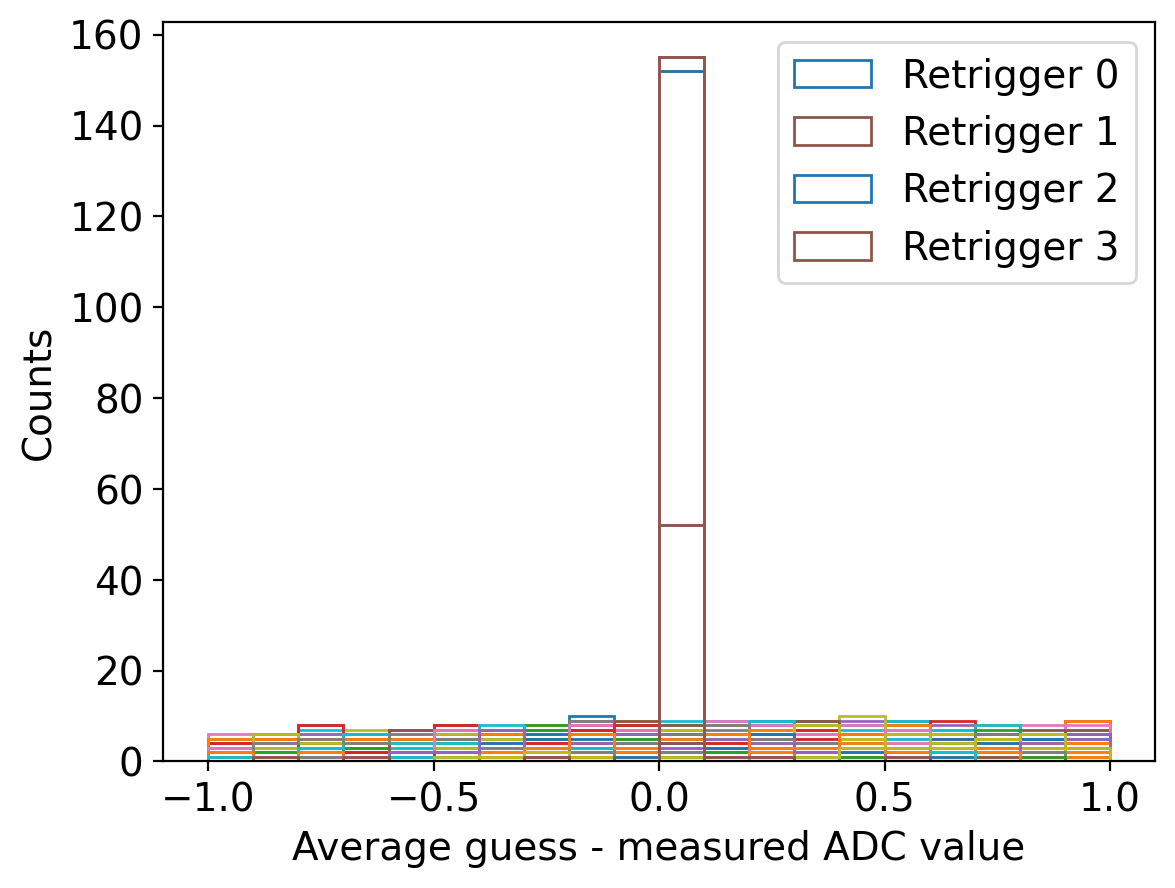

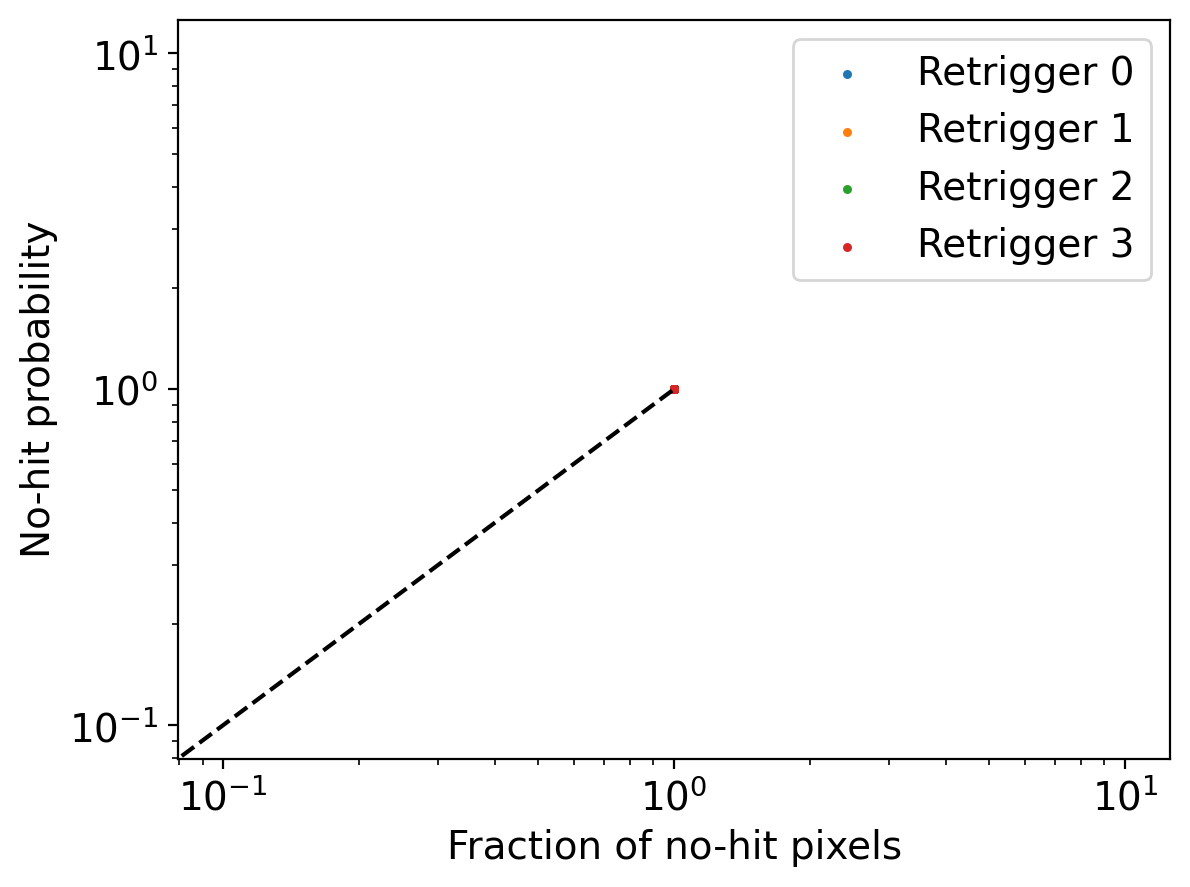

In [265]:
from jax.scipy.special import erf

@jit
def get_adc_values_average_noise(params, pixels_signals):
    q = pixels_signals*params.t_sampling
    q_sum = q.cumsum(axis=-1)  # Cumulative sum over time ticks


    def find_hit(q_sum_loc, it):
        sigma = params.RESET_NOISE_CHARGE #Found out that only considering the reset noise was sufficient
        guess = 0.5*(erf((q_sum_loc[:, 1:] - params.DISCRIMINATION_THRESHOLD)/(jnp.sqrt(2)*sigma)) - erf((q_sum_loc[:, :-1] - params.DISCRIMINATION_THRESHOLD)/(jnp.sqrt(2)*sigma)))
        norm = 0.5*(erf((q_sum_loc[:, -1] - params.DISCRIMINATION_THRESHOLD)/(jnp.sqrt(2)*sigma)) - erf((q_sum_loc[:, 1] - params.DISCRIMINATION_THRESHOLD)/(jnp.sqrt(2)*sigma)))
        no_hit_prob = 1 - norm

        interval = round((3 * params.CLOCK_CYCLE + params.ADC_HOLD_DELAY * params.CLOCK_CYCLE) / params.t_sampling)

        tick_avg  = jnp.sum(guess/ (1-no_hit_prob[:, None])*jnp.arange(guess.shape[1]), axis=1) + 0.5

        shifted_ticks = jnp.arange(guess.shape[1]) + interval + 1

        shifted_ticks = jnp.clip(shifted_ticks, 0, q_sum_loc.shape[1] - 1)
        shifted_ticks2 = jnp.clip(shifted_ticks + 1, 0, q_sum_loc.shape[1] - 1)

        charge_avg1 = jnp.sum(guess*(q_sum_loc[:, shifted_ticks]), axis=1)[:, jnp.newaxis]
        charge_avg2 = jnp.sum(guess*(q_sum_loc[:, shifted_ticks2]), axis=1)[:, jnp.newaxis]

        charge_avg = 0.5*(charge_avg1 + charge_avg2)
        # q_sum_new = q_sum_loc - charge_avg[:, jnp.newaxis]
        q_sum_new = q_sum_loc - charge_avg2

        return q_sum_new, (charge_avg, tick_avg, no_hit_prob)
    
    init_loop = q_sum
    _, (charge_avg, tick_avg, no_hit_prob) = lax.scan(find_hit, init_loop, jnp.arange(0, params.MAX_ADC_VALUES))

    return (charge_avg, tick_avg, no_hit_prob)



charge_avg, tick_avg, no_hit_prob = get_adc_values_average_noise(ref_params, wfs_filtered[:, 1:])
adc_avg = digitize(ref_params, charge_avg)


average_measured = jnp.sum(ticks_filtered*(ticks_filtered < 1998), axis=0)/jnp.sum(ticks_filtered < 1998, axis=0)

for i in range(4):
    plt.scatter(average_measured[:, i], tick_avg[i, :], s=5, label=f'Retrigger {i}')

plt.plot([0, 1000], [0, 1000], color='r', linestyle='--')
plt.xlabel('Average measured tick number')
plt.ylabel('Average guess tick number')
plt.legend()



plt.figure()
for i in range(4):
    plt.hist(tick_avg[i, :] - average_measured[:, i], bins=100, range=(-5, 5), histtype='step', label=f'Average guess - measured ; retrigger {i}');
plt.xlabel('Average guess - measured tick number')
plt.ylabel('Counts')
plt.legend()


average_measured_adc = np.average(filtered, axis=0, weights=(filtered > 74.3567))

plt.figure()
for i in range(4):
    plt.scatter(average_measured_adc[:, i], adc_avg[i, :], s=5, label=f'Retrigger {i}')
plt.xlabel('Average measured ADC value')
plt.ylabel('Average guess ADC value')
plt.legend()

plt.figure()
for i in range(4):
    plt.hist(adc_avg[i, :] - average_measured_adc[:, i], bins=20, range=(-1, 1), histtype='step', label=f'Retrigger {i}');
plt.xlabel('Average guess - measured ADC value')
plt.ylabel('Counts')
plt.legend()

# print("Std of average guess - measured ADC:", np.std(average_guess_adc - average_measured_adc))

# # average_guess_adc =  np.sum(guess * digitize(ref_params, q_sum[:, shifted_ticks]), axis=1)
# # plt.scatter(average_measured_adc, average_guess_adc, s=1)

# plt.plot([70, 110], [70, 110], color='k', linestyle='--')
# plt.figure()
# plt.hist(average_guess_adc - average_measured_adc, bins=100, range=(-3, 3), histtype='step', label='Average guess - measured');
# plt.xlabel('Average guess - measured ADC value')
# plt.ylabel('Counts')
# print(np.argsort(np.abs(average_guess_adc - average_measured_adc))[::-1])
# print(average_guess_adc[iplot], average_measured_adc[iplot])

# plt.figure()
# plt.scatter(average_measured_adc, average_guess_adc - average_measured_adc, s=5)
# plt.scatter(average_measured_adc, average_guess_adc2 - average_measured_adc, s=5)

# plt.xlabel('Average measured ADC value')
# plt.ylabel('Average guess - measured ADC value')

plt.figure()

measured_no_hit_prob = np.mean((ticks_filtered == 1998), axis=0)
for i in range(4):
    plt.scatter(measured_no_hit_prob[:, i], no_hit_prob[i, :], s=5, label=f'Retrigger {i}')
plt.xlabel('Fraction of no-hit pixels')
plt.ylabel('No-hit probability')
plt.plot([0, 1], [0, 1], color='k', linestyle='--')
plt.xscale('log')
plt.yscale('log')
plt.legend()


No hit probability for pixel 931 : [1.        1.        1.        ... 1.        1.        0.9996083]


Array(362.87668, dtype=float32)

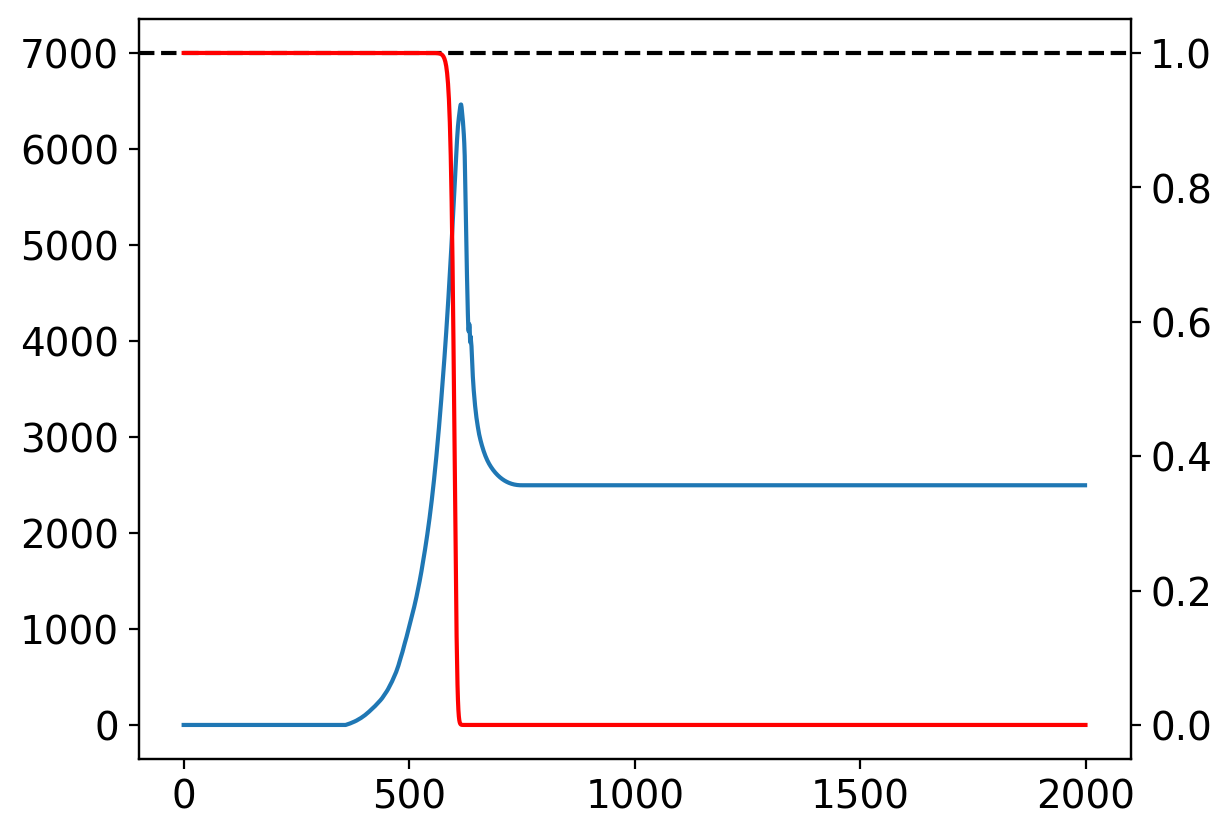

In [325]:

iplot = 931
print("No hit probability for pixel", iplot, ":", no_hit_prob[iplot])
noise_rng_key = jax.random.key(5)
plt.plot(q_sum[iplot, 1:])
plt.axhline(ref_params.DISCRIMINATION_THRESHOLD, color='k', linestyle='--')
ax2 = plt.gca().twinx()

lower_term = 0.5*(1 + erf((ref_params.DISCRIMINATION_THRESHOLD - q_sum)/(np.sqrt(2)*sigma)))
upper_term = 1-lower_term

prob = (1 - phi((ref_params.DISCRIMINATION_THRESHOLD - q_sum)/sigma))**2

guess = (upper_term[:, 1:]*lower_term[:, 1:])
# guess = 0.5*(erf((q_sum[:, 1:] - ref_params.DISCRIMINATION_THRESHOLD)/(np.sqrt(2)*sigma)) - erf((q_sum[:, :-1] - ref_params.DISCRIMINATION_THRESHOLD)/(np.sqrt(2)*sigma)))
# norm = 0.5*(erf((q_sum[:, -1] - ref_params.DISCRIMINATION_THRESHOLD)/(np.sqrt(2)*sigma)) - erf((q_sum[:, 1] - ref_params.DISCRIMINATION_THRESHOLD)/(np.sqrt(2)*sigma)))
# guess = guess / norm[:, None]

xmax = jnp.argmax(guess, axis=1)
xl = xmax - 10
xh = xmax + 10

# guess = 0.5*(erf((q_sum[:, 1:] - ref_params.DISCRIMINATION_THRESHOLD)/(np.sqrt(2)*sigma)) - erf((q_sum[:, :-1] - ref_params.DISCRIMINATION_THRESHOLD)/(np.sqrt(2)*sigma)))
# norm = 0.5*(erf((q_sum[:, -1] - ref_params.DISCRIMINATION_THRESHOLD)/(np.sqrt(2)*sigma)) - erf((q_sum[:, 1] - ref_params.DISCRIMINATION_THRESHOLD)/(np.sqrt(2)*sigma)))
# guess = guess / norm[:, None]

# ax2.plot(guess[iplot, :], color='red')
# ax2.plot(digitize(ref_params, q_sum[:, shifted_ticks])[iplot, :], color='red', label='Digitized ADC values')
ax2.plot(np.cumprod(prob[iplot, :]), color='red')
shifted_ticks = np.clip(np.arange(guess.shape[1]) + interval + 1, 0, q_sum.shape[1] - 1)
average_guess_adc = np.sum(guess*digitize(ref_params, q_sum[:, shifted_ticks]), axis=1)
average_guess_adc[iplot]
# plt.xlim(400, 700)

# plt.figure()
# plt.hist(filtered[:, iplot, 0], bins=np.arange(70, 100), density=True, histtype='step', label='Measured ADC distribution')
# plt.hist(digitize(ref_params, (guess * q_sum[iplot, shifted_ticks]).flatten()), bins=np.arange(70, 100), density=True, histtype='step', label='Predicted ADC distribution')




In [104]:
ref_params.RESET_NOISE_CHARGE

900

[74.36561584 74.36561584 74.36561584 74.36561584 74.36561584 74.36561584
 74.36561584 74.36561584 74.36561584 74.36561584 74.36561584 74.36561584
 74.36561584 74.36561584 74.36561584 74.36561584 74.36561584 74.36561584
 74.36561584 74.36561584 74.36561584 74.36561584 74.36561584 74.36561584
 74.36561584 74.36561584 74.36561584 74.36561584 74.36561584 74.36561584
 74.36561584 74.36561584 74.36561584 74.36561584 74.36561584 74.36561584
 74.36561584 74.36561584 74.36561584 74.36561584 74.36561584 74.36561584
 74.36561584 74.36561584 74.36561584 74.36561584 74.36561584 74.36561584
 74.36561584 74.36561584 74.36561584 74.36561584 74.36561584 74.36561584
 74.36561584 74.36561584 74.36561584 74.36561584 74.36561584 74.36561584
 74.36561584 74.36561584 74.36561584 74.36561584 74.36561584 74.36561584
 74.36561584 81.75991821 74.36561584 74.36561584 74.36561584 74.36561584
 74.36561584 74.36561584 74.36561584 74.36561584 74.36561584 74.36561584
 74.36561584 74.36561584 74.36561584 74.36561584 74

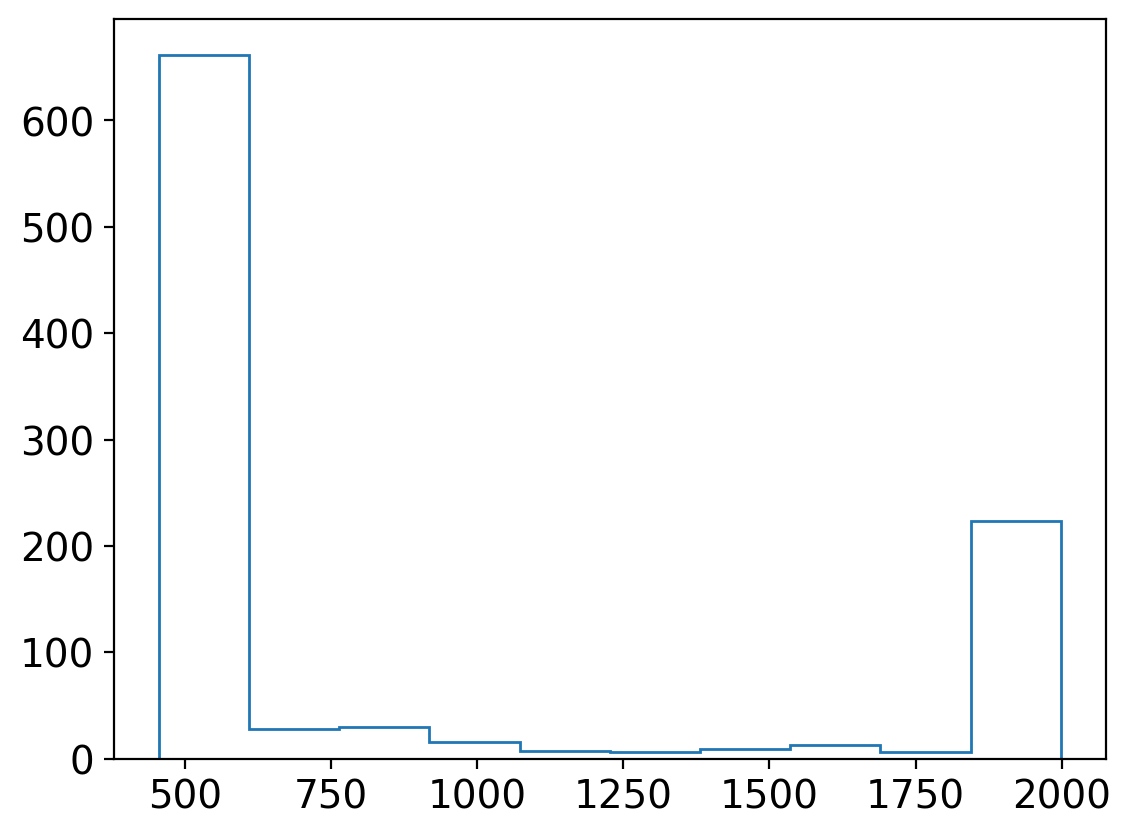

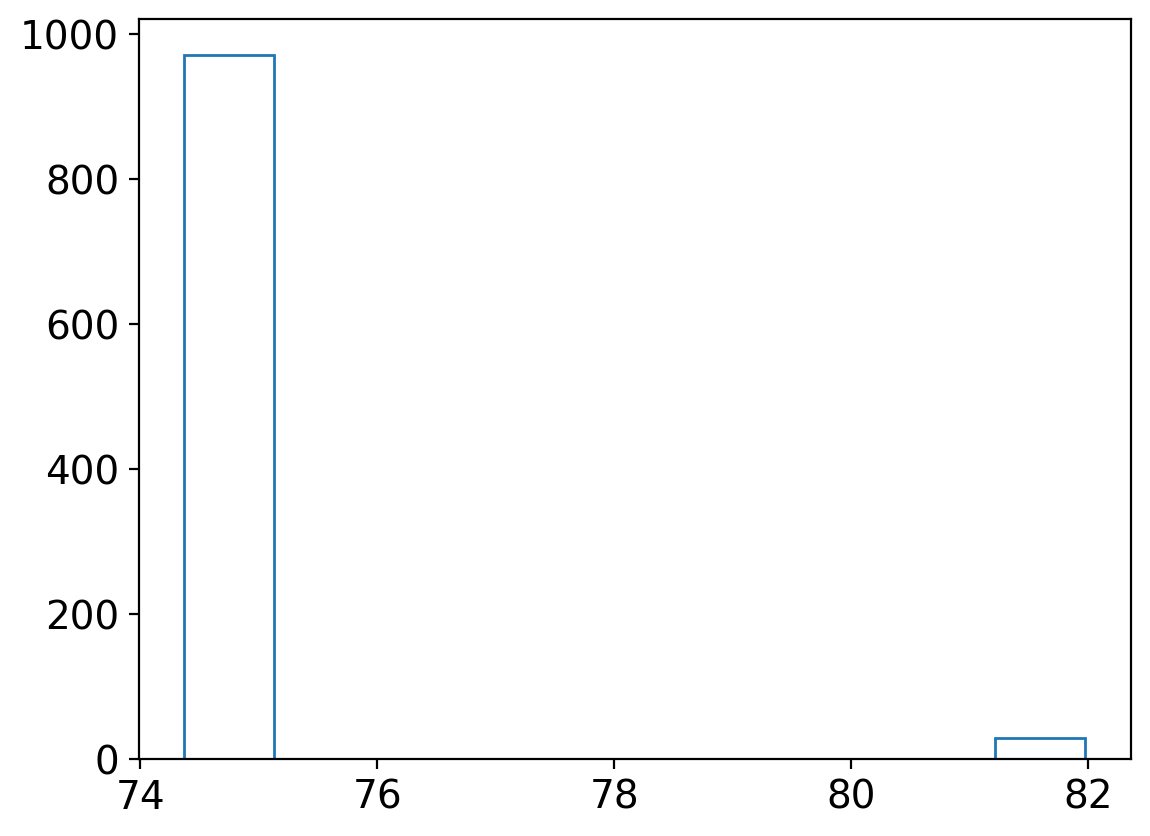

In [134]:
plt.hist(ticks_filtered[:, iplot, 0], histtype='step', label='Measured tick distribution')
plt.figure()
plt.hist(filtered[:, iplot, 0], histtype='step', label='Measured tick distribution')
print(filtered[:, iplot, 0])

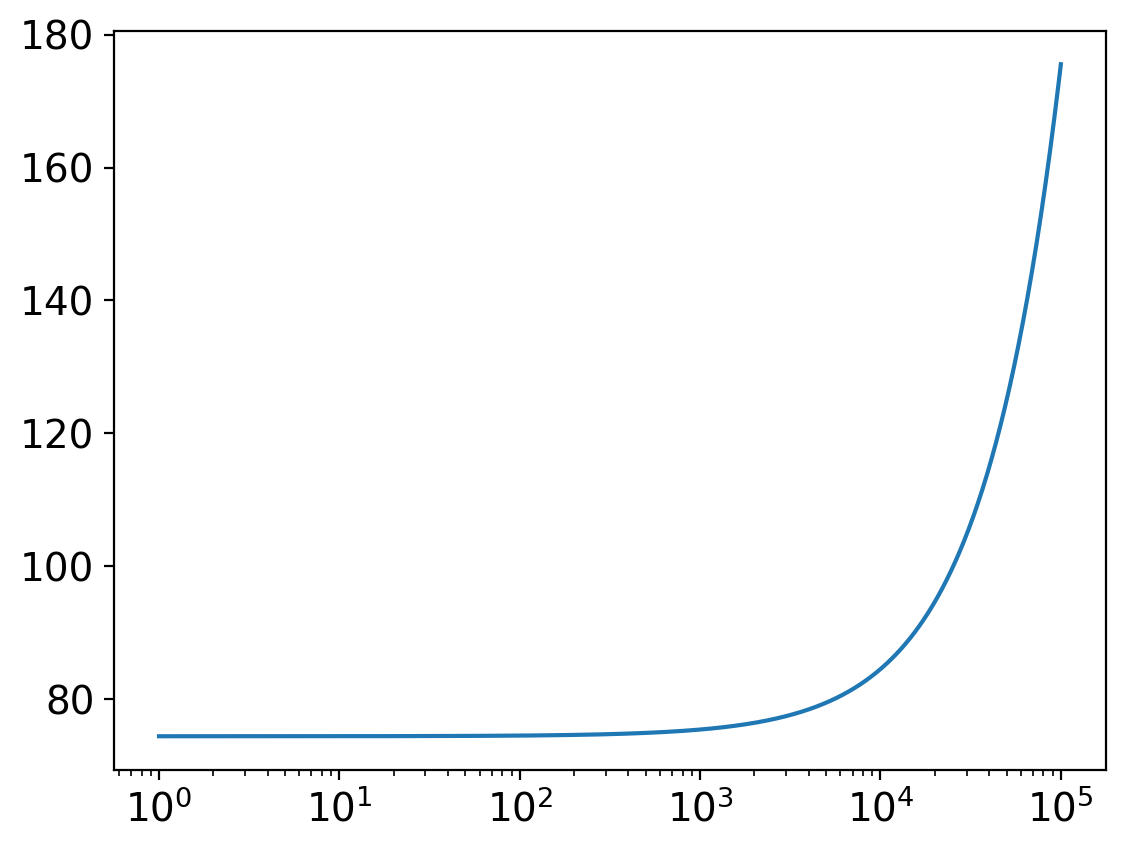

In [127]:
x = np.logspace(0, 5, 1000)
plt.figure()
plt.plot(x, digitize(ref_params, x), label='Digitized ADC values')
plt.xscale('log')

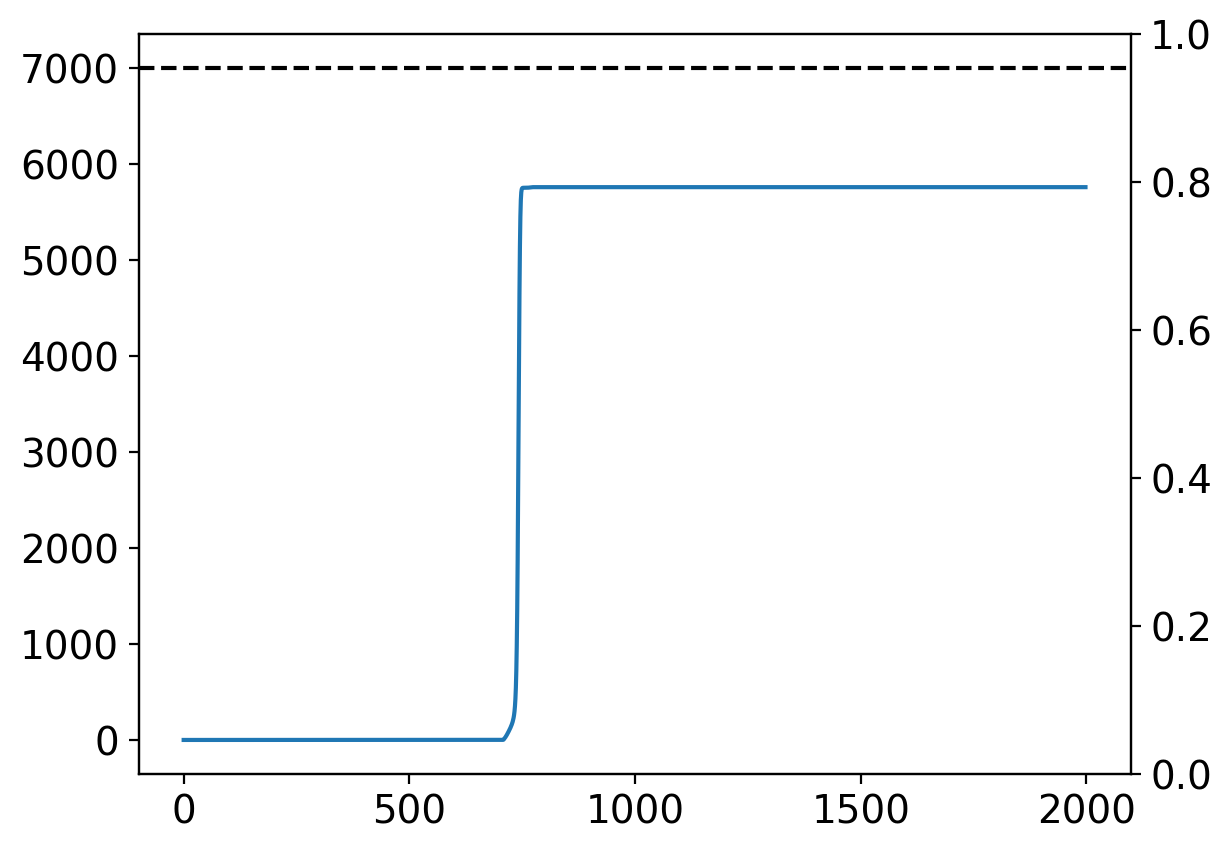

In [ ]:
plt.plot(q_sum[iplot, 1:])
plt.axhline(ref_params.DISCRIMINATION_THRESHOLD, color='k', linestyle='--')
ax2 = plt.gca().twinx()

guess = (upper_term[:, 1:]*lower_term[:, 1:])
# guess = 0.5*(erf((q_sum[:, 1:] - ref_params.DISCRIMINATION_THRESHOLD)/(np.sqrt(2)*sigma)) - erf((q_sum[:, :-1] - ref_params.DISCRIMINATION_THRESHOLD)/(np.sqrt(2)*sigma)))
# norm = 0.5*(erf((q_sum[:, -1] - ref_params.DISCRIMINATION_THRESHOLD)/(np.sqrt(2)*sigma)) - erf((q_sum[:, 1] - ref_params.DISCRIMINATION_THRESHOLD)/(np.sqrt(2)*sigma)))
# guess = guess / norm[:, None]

xmax = jnp.argmax(guess, axis=1)
xl = xmax - 10
xh = xmax + 10

# guess = 0.5*(erf((q_sum[:, 1:] - ref_params.DISCRIMINATION_THRESHOLD)/(np.sqrt(2)*sigma)) - erf((q_sum[:, :-1] - ref_params.DISCRIMINATION_THRESHOLD)/(np.sqrt(2)*sigma)))
# norm = 0.5*(erf((q_sum[:, -1] - ref_params.DISCRIMINATION_THRESHOLD)/(np.sqrt(2)*sigma)) - erf((q_sum[:, 1] - ref_params.DISCRIMINATION_THRESHOLD)/(np.sqrt(2)*sigma)))
# guess = guess / norm[:, None]

# ax2.plot(guess[iplot, :], color='red')
# plt.xlim(850, 1000)

# plt.figure()
# plt.hist(filtered[:, iplot, 0], bins=np.arange(70, 100), density=True, histtype='step', label='Measured ADC distribution')
# plt.hist(digitize(ref_params, (guess * q_sum[iplot, shifted_ticks]).flatten()), bins=np.arange(70, 100), density=True, histtype='step', label='Predicted ADC distribution')


In [85]:
digitize(ref_params, (guess * q_sum[iplot, shifted_ticks]).flatten()).max()

Array(78.26325, dtype=float32)

ValueError: Too many bins for data range. Cannot create 10 finite-sized bins.

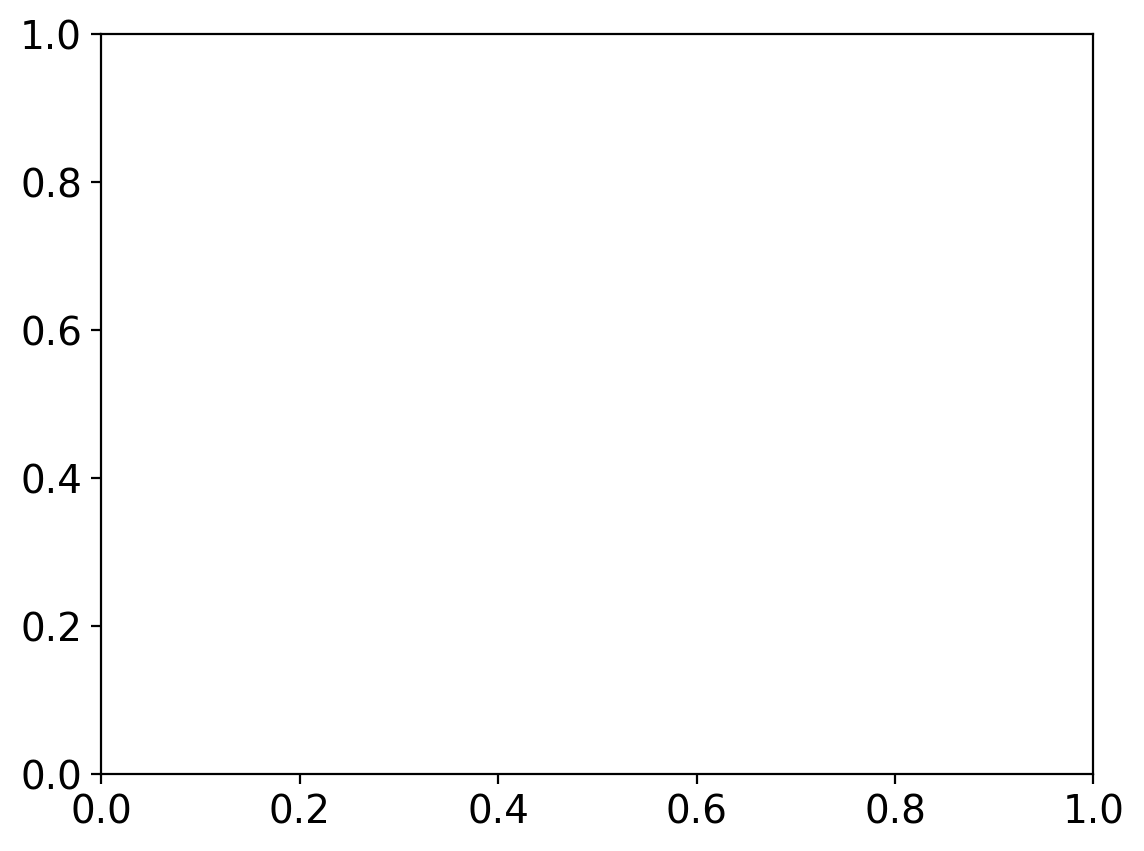

In [ ]:

# plt.hist(erf((q_sum[:, 1] - ref_params.DISCRIMINATION_THRESHOLD)/(np.sqrt(2)*sigma)), bins=20, histtype='step', label='Predicted')

# print(np.sum(guess, axis=1).shape, norm.shape)
plt.hist(np.sum(guess, axis=1)/norm, histtype='step', label='Predicted')
# plt.hist(norm, bins=20, histtype='step', label='Predicted')

In [129]:
np.sum(guess, axis=1)/norm

array([1.0000001 , 1.        , 1.        , 1.        , 1.        ,
       1.0000001 , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.0000001 , 1.        ,
       1.        , 0.99999994, 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       0.99999994, 0.99999994, 1.        , 1.        , 1.        ,
       1.        , 1.        , 0.99999994, 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 0.99999994, 1.        , 1.        , 1.        ,
       1.        , 1.        , 0.9999999 , 1.        , 1.        ,
       1.        , 1.        , 0.99999994, 1.        , 0.9999999 ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       0.99999994, 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.     

In [49]:
sorted(guess[iplot], reverse=True)

[np.float64(0.0007856742013183861),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float6

In [1]:
q_sum = np.cumsum(wfs_filtered[:, 1:], axis=1)*ref_params.t_sampling
selec_func = lambda x: jnp.where((x[1:] >= ref_params.DISCRIMINATION_THRESHOLD) & 
            (x[:-1] <= ref_params.DISCRIMINATION_THRESHOLD), size=1, fill_value=q_sum.shape[1]-2)
idx_t, = jax.vmap(selec_func, 0, 0)(q_sum)
idx_t = idx_t.ravel()

# plt.scatter(idx_t, ticks_nonoise_filtered[:, 0])
plt.hist(idx_t - ticks_nonoise_filtered[:, 0], bins=np.linspace(-3, 3, 60));
# plt.plot(np.linspace(200, 1000, 100), np.linspace(200, 1000, 100), color='r')
# plt.ylim(200, 1200)

NameError: name 'np' is not defined

In [13]:
ticks_nonoise_filtered[:, 0]

Array([ 542.34796,  529.465  ,  517.7613 ,  455.84897,  323.84268,
        307.4467 ,  281.33017,  243.21832,  197.68945,  173.12006,
        160.15947,  116.57404,  864.79004,  874.3673 ,  884.63135,
        895.9629 ,  908.4097 ,  921.73914,  934.8167 ,  733.7697 ,
        732.57385,  742.73065,  754.22797,  769.7104 ,  778.4072 ,
        791.69464,  804.37555,  818.40875,  833.27936,  849.0465 ,
        602.36725,  612.2777 ,  623.0723 ,  635.01715,  648.05786,
        661.0774 ,  674.34955,  688.7229 ,  704.1078 ,  721.1015 ,
        566.68225,  608.47144,  626.24176,  627.8626 ,  638.35535,
        126.09506,  136.0873 ,  160.14565,  184.5785 ,  209.63347,
        226.72855,  231.7803 ,  252.41705,  272.62335,  293.77203,
        315.48242,  337.6772 ,  360.42606,  383.04453,  405.5378 ,
        428.55704,  452.05447,  476.09702,  500.6435 ,  525.3581 ,
        549.9999 ,  546.93164,  566.14777,  585.12274,  605.1518 ,
        625.95624,  647.4304 ,  669.1254 ,  690.5698 ,  712.83

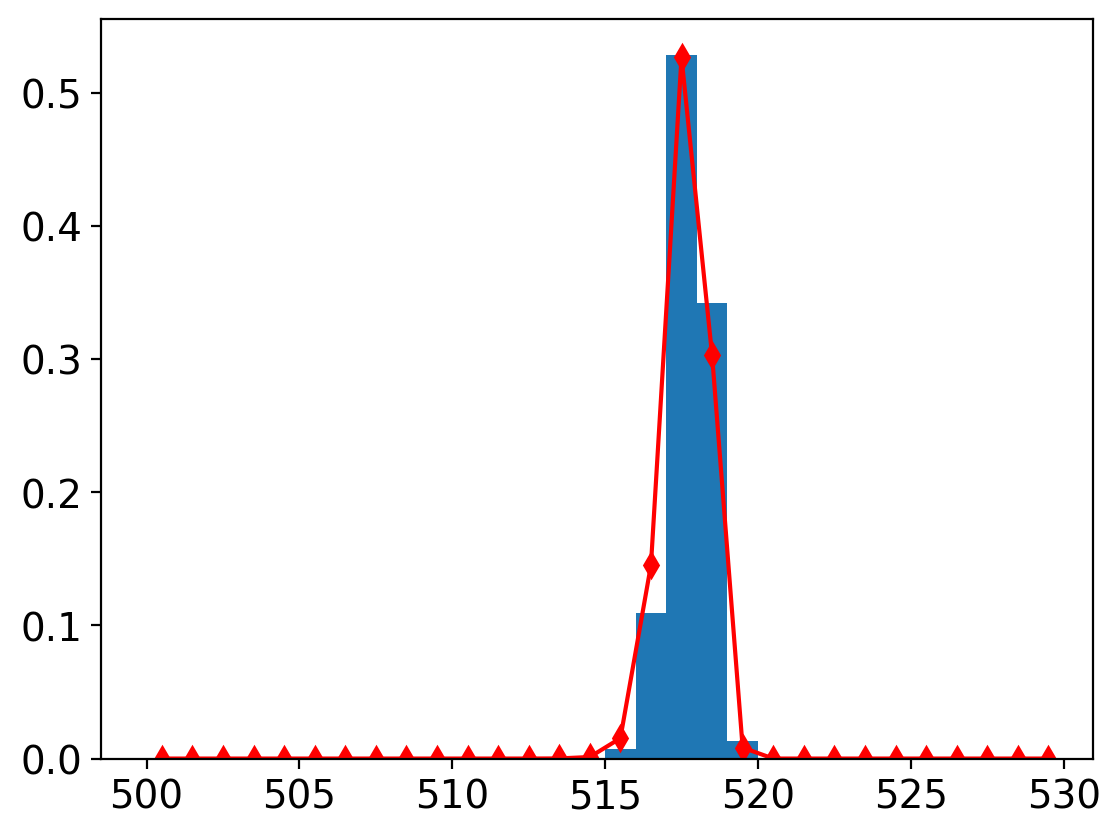

In [65]:
ticks_nonoise_filtered[1, :]

Array([ 529.465, 1998.   , 1998.   , 1998.   , 1998.   , 1998.   ,
       1998.   , 1998.   , 1998.   , 1998.   ], dtype=float32)

In [45]:
wfs_filtered.shape

(467, 2001)

In [29]:
(upper_term[1:]*lower_term[1:])[515:535]

array([1.96694003e-05, 6.69938517e-05, 2.13245500e-04, 6.45499104e-04,
       1.87754498e-03, 5.26121349e-03, 1.41246926e-02, 3.57345064e-02,
       8.24643731e-02, 1.63995430e-01, 2.55365212e-01, 2.65951593e-01,
       1.44659372e-01, 2.84452746e-02, 1.16450181e-03, 3.99391580e-06,
       2.45688801e-10, 2.19662940e-17, 0.00000000e+00, 0.00000000e+00])

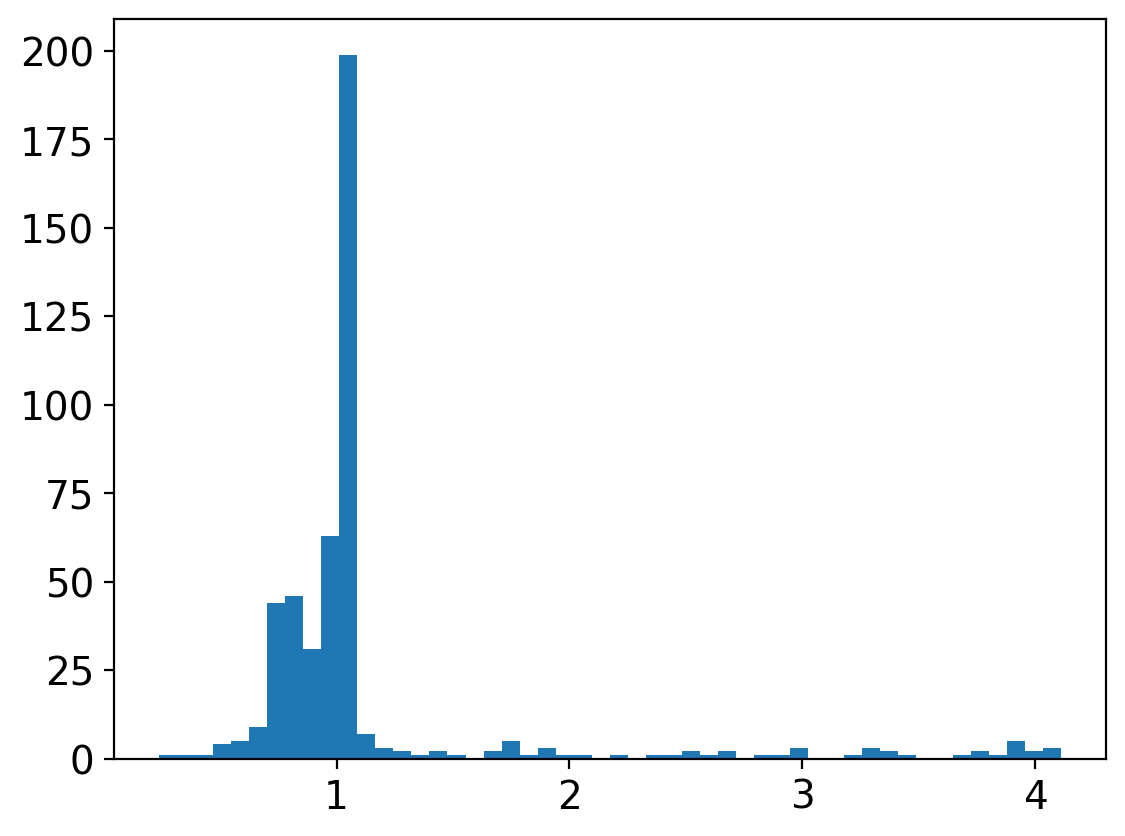

In [32]:
plt.hist(filtered[:, :, 0].std(axis=0), bins=50);

Text(0, 0.5, 'std')

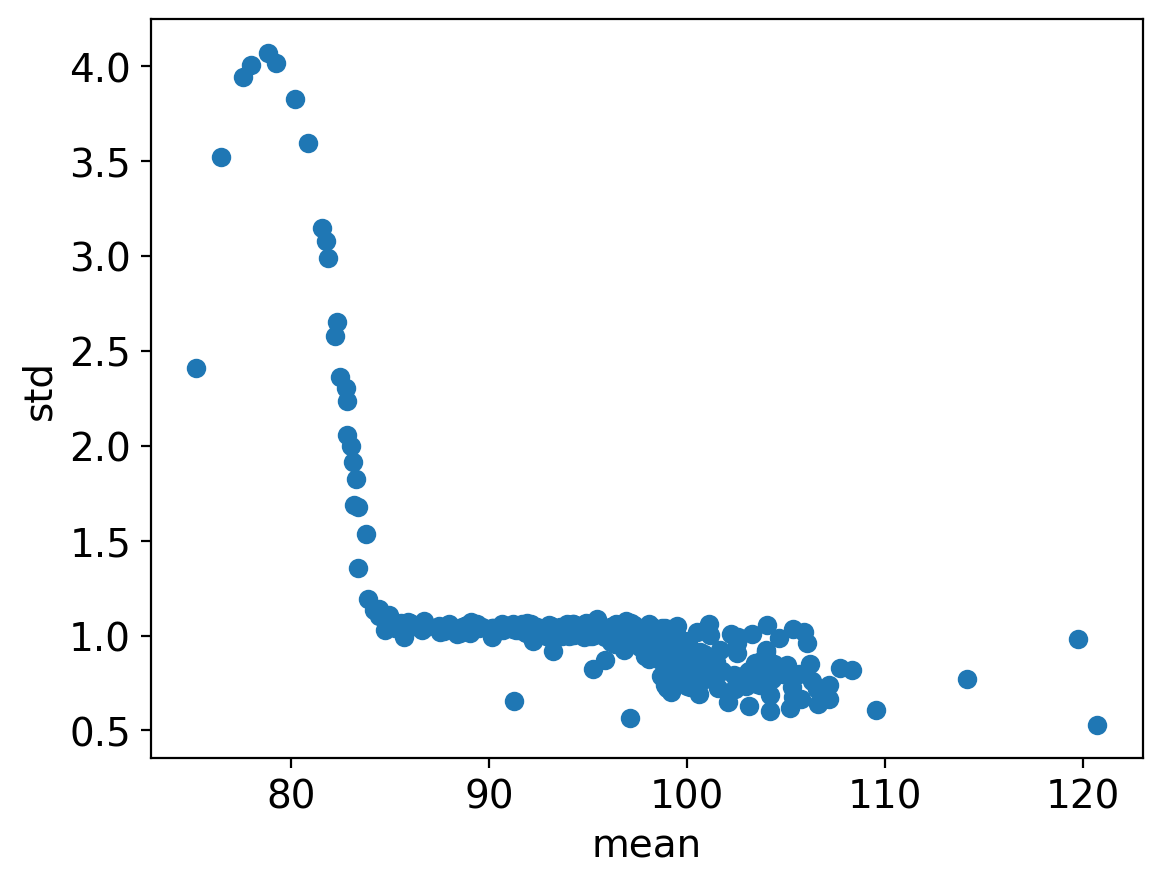

In [35]:
plt.scatter(filtered[:, :, 0].mean(axis=0), filtered[:, :, 0].std(axis=0))
plt.xlabel('mean')
plt.ylabel('std')